# **19高阶RAG：基于知识图谱的RAG**

## 过场介绍

**"知识图谱作为结构化知识的代表，正在深刻改变我们获取和利用信息的方式。** 在本文中，我们将从基础概念出发，首先解析​**知识图谱的本质**​——它如何以『实体-关系-属性』的形式组织海量信息，使机器能够像人类一样理解世界的关联性。

接着，我们将探讨​**知识图谱在搜索引擎中的应用**​，看看它如何帮助Google实现从『关键词匹配』到『语义理解』让搜索更智能、更精准。

而在当今大模型时代，知识图谱与RAG（检索增强生成）系统的结合，进一步释放了结构化知识的潜力。我们将深入分析​**知识图谱如何优化RAG的检索过程**​——它不仅能够提供更精确的上下文片段，还能通过实体关系增强语义连贯性。

为了更直观地理解这一技术融合，之后我们将介绍两个**基于知识图谱的RAG开源实现方案** GraphRAG和LightRAG，剖析它们的设计思路和关键技术。

最后，我们将通过**实战**和两个**案例分析**说明知识图谱如何显著提升RAG系统的准确性和。

## 背景介绍

RAG(​***Retrieval Augmented Generation***​) 是 LLM 问世以来生成式 AI 领域最热门话题之一，它是结合了**​检索（Retrieval）​**和**​生成（Generation）​**的AI技术，旨在通过外部知识库增强大语言模型（LLM）的生成能力。其核心思想是：

​**先检索**​：从外部知识库（如文档、数据库）中查找与问题相关的信息片段。

​**后生成**​：将检索到的内容作为上下文，输入给大语言模型，生成更准确、可靠的回答。

一般RAG（Retrieval-Augmented Generation）系统中，效果优化策略大致可以分为两个核心方向：检索阶段的优化和生成阶段的优化。而基于知识图谱的RAG正是优化的检索环节。

传统的、也被称作朴素RAG（naive RAG）的流程，通常包括对私有知识库中的内容进行文本切分、向量化编码以及索引构建等步骤。随后，系统根据用户查询在向量索引中检索相关内容片段，并将这些被召回的内容作为上下文输入给大语言模型，用于生成回答。在朴素RAG中，检索返回的内容往往是孤立、缺乏结构关联的文本块。这种方式在回答在需要跨文档、跨段落推理的场景中，由于召回片段之间缺乏逻辑和语义连贯性，容易导致生成结果不准确或片面。此外，RAG还面临结构缺失的问题，无法识别文档间的主题关系，以及信息冗余与漏召的问题，导致重要信息遗漏或内容重复。这些限制显著影响了其在复杂问答、逻辑推理和多跳检索等等高阶任务中的表现。

为了解决朴素RAG在检索召回上碎片化的局限，基于知识图谱的RAG（Knowledge Graph-based RAG,  也有称为Knowledge-enabled RAG/ Knowledge Graph Guided RAG）技术应运而生。Knowledge Graph-based RAG 在知识建模层引入了结构化语义网络，即知识图谱，用于明确刻画实体之间的关系与上下文结构。知识图谱通过实体-关系-属性的三元组形式显式建模语义关联，使系统能够清晰刻画知识之间的语义路径。通过在图谱上进行结构感知的检索或路径遍历，系统可以更有针对性地召回与用户问题语义相关、逻辑连贯的信息，显著提升回答的准确性和解释性。此外，知识图谱还支持跨文档实体的对齐与融合，增强主题聚合与复杂推理能力，从而更好地应对多跳问答和高阶逻辑推理任务。

## **知识图谱：让机器理解世界的“知识网络”**

图是一种由一组节点（或称为顶点）和节点之间的边组成的数据结构，可以用来表示各种关系和结构。例如图1 可以表示地铁路线图，每个顶点表示一个站点，每个边表示站点之间的连通性；也可以表示社交网络中的好友关系，每个顶点表示一个社交软件用户，每条边表示二者为好友关系。

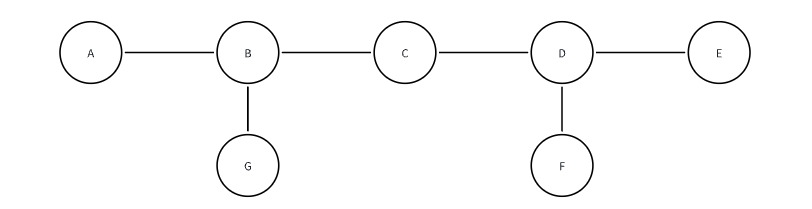

图1 图（Graph）结构

知识图谱（Knowledge Graph, KG）是一种用 “图” 结构表示知识的方式，由实体（节点）和关系（边）组成，能够将各种信息抽象成结构化的形式，进而支持机器对其进行理解、推理和查询。

知识图谱通常由三元组组成，其中每个三元组包含一个实体、关系以及与该实体相关的另一个实体，结构形式为 （实体1）—[关系]→（实体2）。比如，“阿基米德”是一个实体，“发现”是一个关系，“浮力原理”是另一个实体。通过这种形式，知识图谱能够把知识表示为一个网络或图结构，便于存储、查询和推理。

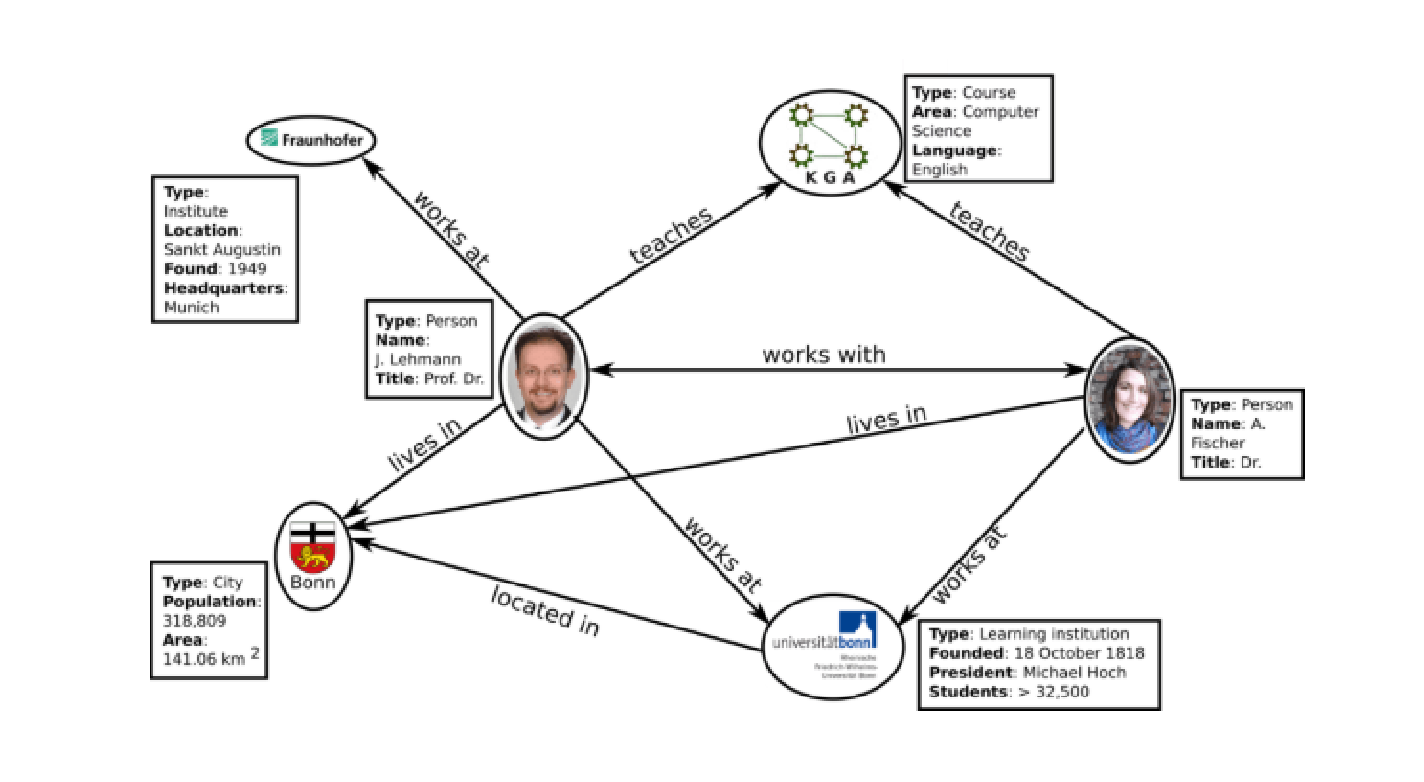

图2 知识图谱示例（图源网络）

知识图谱有三个重要组成部分，即实体，关系和属性，每个部分的解释如下：

* 实体（Entity）：知识图谱的基本构成单位，代表现实世界中的物品、概念、事件等。例如图2中的每个人物、城市、课程都是实体。
* 关系（Relationship）：描述实体间联系的方式，通常用边来表示。比如图2中男士与Bonn的关系是“lives in”，表示这位男士生活在Bonn City。
* 属性（Attribute）：实体或关系的附加信息。例如图2中Bonn City有“Type”，“Population”和“Area”三个属性。

知识图谱可以将零散的信息组织成有结构的图，可以清晰地展现实体之间的关系。例如，在医疗领域中，可以通过知识图谱将疾病、症状、治疗方案等信息用图的形式联系起来。知识图谱中每个边连接不同的实体，可以通过这种连接关系实现复杂的多层次、多跳推理。不同于传统数据库的表格形式，知识图谱能更自然地表示复杂的关联信息，不仅包含实体之间的关系，还可以标注关系的类型、方向等信息，使得计算机能够理解不同类型的关系。此外，由于知识图谱能够不断扩展，随着更多的数据和知识加入，图谱能够持续成长，表示更复杂更多样的信息，适用于海量知识的表示。

## 从文档中构建知识图谱

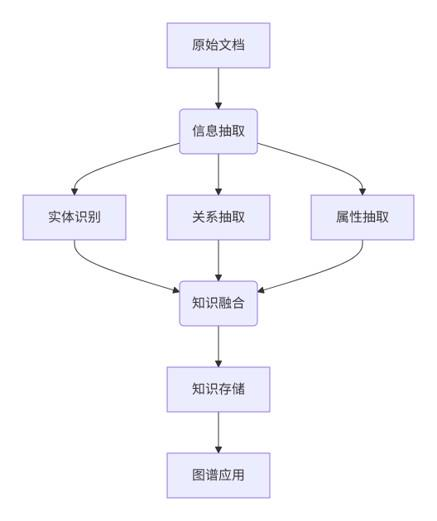

从文档中构建知识图谱通常包括以下步骤：首先，通过文档解析将 PDF、Word、网页等非结构化文档转化为纯文本，同时清除格式和乱码。接着，通过信息抽取技术识别文本中的实体、关系和属性，生成初步的结构化三元组。随后，通过知识融合对同一实体进行合并，解决多义词和冲突信息问题。将处理后的三元组存入图数据库中，便于高效查询与分析。最终，知识图谱可用于可视化展示、智能问答以及企业决策辅助等实际应用场景。

## **从搜索到问答：知识图谱如何升级搜索引擎**

知识图谱应用于搜索引擎中最初见于2012年Google的[ Introducing the Knowledge Graph: things, not strings](https://blog.google/products/search/introducing-knowledge-graph-things-not/), 文中提出其对搜索的效果提升主要体现在三个方面

1. Find the right thing

理解字符串所代表的实体

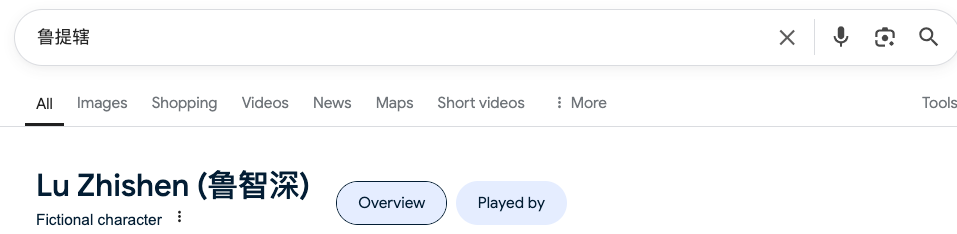

2. Get the best summary

围绕主题汇总相关内容，而非简单返回其所出现在的原文

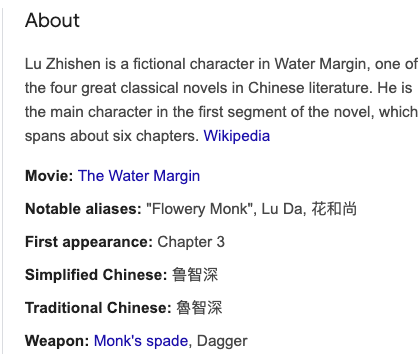

3. Go deeper and broader

从深度和广度上扩大召回。比如：“关联问题推荐”

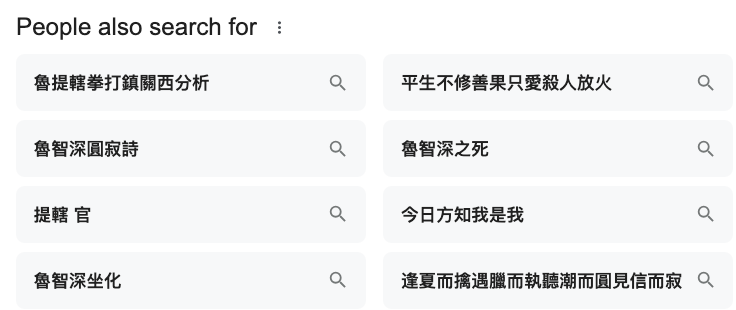

## **RAG系统的“智能外挂”：知识图谱如何赋能RAG？**

### RAG系统如何构建知识图谱

基于知识图谱的RAG系统需要首先从现有的结构化数据（如数据库、RDF、Neo4j等）和非结构化数据（如文本）构建出知识图谱。

结构化数据通常已有明确的实体与关系，而非结构化数据（通常是文本文档）则需要专门提取对应信息，例如重要的实体（如人名、地名、日期等）与它们之间的关系（如“创办了”或“位于”）。

从非结构化文本中构建知识图谱时，可以利用自然语言处理（NLP）中的命名实体识别（NER）和关系抽取技术，也可以通过 LLM 进行提取。目前多数方法直接使用 LLM 提取文档中的实体与关系再构造对应的知识图谱，流程如图所示：

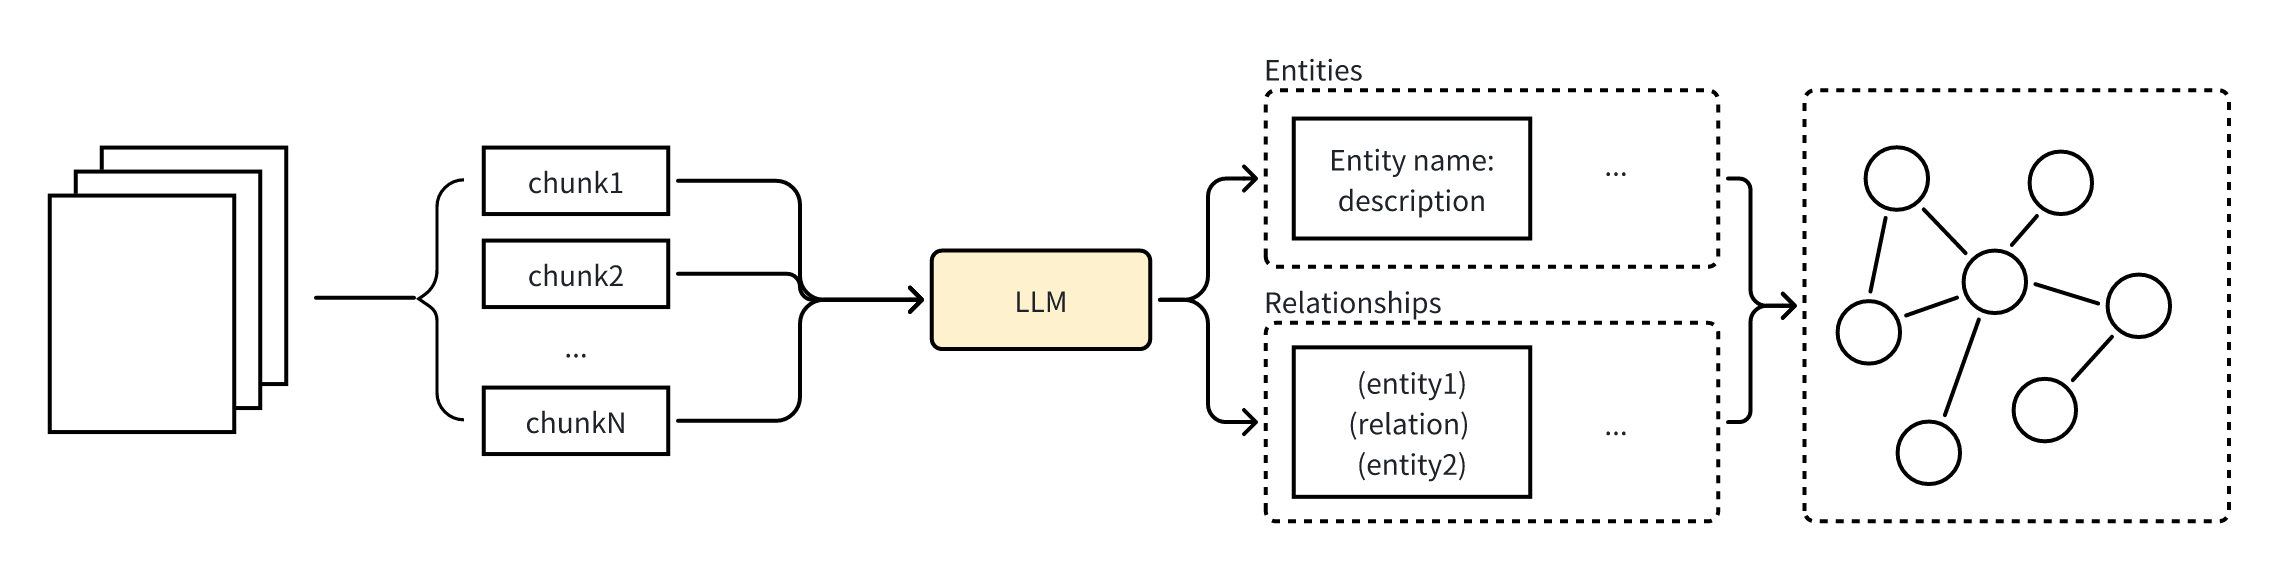

图4 利用大模型构建知识图谱流程

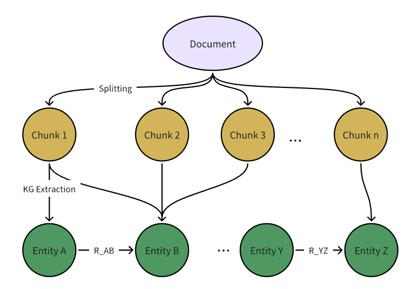

首先对文本进行分块，这一步与普通RAG中的分块方法一致。在选择文本块粒度时，必须在召回率和精确率之间找到平衡。微软 GraphRAG 工作中指出较长的文本块可能导致召回率下降，影响图谱索引的质量。这是因为较长的文本块虽然可以减少LLM调用次数，但由于LLM上下文窗口的限制，可能会导致信息丢失从而降低召回率。

文本分块后，使用LLM提示从文本块中提取图元素实例(节点、边、协变量)。这一步可以通过 Prompt 提示分为两个步骤实现：（1）识别文本中出现的所有实体（包括实体名、类型和描述）; （2）识别相关实体之间的关系（包括源实体、目标实体和关系描述）。具体实践中，可以根据任务所属的领域进行 Prompt 定制，例如针对科学、医学、法律等不同专业领域，可以使用对应的示例来提高提取质量。

最后合并不同文档/分片中已存在的实体和关系。


**从内容片段构建知识图谱示例**

原文

```text
起灯烛荧煌，焚起香来。宋江在当中证盟，朝着涌金门下哭奠。戴宗立在侧边。先是僧人摇铃诵咒，摄召呼名，祝赞张顺魂魄，降坠神幡。次后戴宗宣读祭文。宋江亲自把酒浇奠，仰天望东而哭。正哭之间，只听得桥下两边，一声喊起，南北两山，一齐鼓响，两彪军马来拿宋江。正是：方施恩念行仁义，翻作勤王小战场。正是：直诛南国数员将，搅动西湖万丈波。毕竟宋江、戴宗怎地迎敌，且听下回分解。此一回内，折了三员将佐：郝思文、徐宁、张顺。京师取回一员将佐：安道全\n第一百五十五段  话说浙江钱塘西湖这个去处，果然天生佳丽，水秀山明。正是帝王建都之所，名实相孚，繁华第一。自古道：江浙昔时都会，钱塘自古繁华。却才说不了宋江和戴宗正在西陵桥上祭奠张顺，不期方天定已知，着令差下十员首将，分作两路来拿宋江，杀出城来。南山五将是吴值、赵毅、晁中、元兴、苏泾；北山路也差五员首将，是温克让、崔彧、廉明、茅迪、汤逢士。南兵两路，共十员首将，各引三千人马，半夜前后开门，两头军兵一齐杀出来。宋江正和戴宗奠酒化纸，只听得桥下喊声大举。左有樊瑞、马麟，右有石秀，各引五千人埋伏。听得前路火起，一齐也举起火来。两路分开，赶杀南北两山军马。南兵见有准备，急回旧路。两边宋兵追赶。温克让引着四将急回过河去时，不提防保叔塔山背后撞出阮小二、阮小五、孟康，引五千军杀出来，正截断了归路，活捉了茅迪，乱枪戳死汤逢士。南山吴值，也引着四将，迎着宋兵追赶，急退回来，不提防定香桥正撞着李逵、鲍旭、项充、李衮，引五百步队军杀出来。那两个牌手，直抢入怀里来，手舞蛮牌，飞刀出鞘，早剁倒元兴。鲍旭刀砍死苏泾，李逵斧劈死赵毅。接入中军帐坐下。宋江对军师说道：“我如此行计，已得他四将之首，活捉了茅迪，将来解赴张招讨军前，斩首施行。”宋江在寨中，惟不知独松关、德清二处消息。便差戴宗去探，急来回报。戴宗去了数日，回来寨中，参见先锋，说知：“卢先锋已过独松关了，早晚便到此间。”宋江听了，忧喜相半，又问：“兵将如何？”戴宗答道：“我都知那里厮杀的备细，更有公文在此。先锋请休烦恼。”宋江道：“莫非又损了我几个弟兄？你休隐避，可与我实说情由。”戴宗道：“卢先锋自从去取独松关，那关两边都是高山，只中间一条路，山上盖着关所。关边有一株大树，可高数十余丈，望得诸处皆见。下面尽是丛丛杂杂松树。关上守把三员贼将，为首的唤做吴升，第二个是蒋印，第三个是卫亨。初时连日下关和林冲厮杀，被林冲蛇矛戳伤蒋印。吴升不敢下关，只在关上守护。次后厉天闰又引四将到关救应，乃是厉天祐、张俭、张韬、姚义四将。次日下关来厮杀。贼兵内厉天祐首先出马和吕方相持，约斗五六十合，被吕方一戟刺死厉天祐。贼兵上关去了，并不下来。连日在关下等了数日。卢先锋为见山岭险峻，却差欧鹏、邓飞、李忠、周通四个上山探路。不提防厉天闰要替兄弟复仇，引贼兵冲下关来，首先一刀，斩了周通。李忠带伤走了。若是救应得迟时，都是休了的。救得三将
```

这段原文是征方腊时的独松关之战的内容，其中有两个难点：

1. 实体歧义，卢先锋实际上是卢俊义，但片段原文未体现
2. 这段内容出现人物众多，且无主要人物

`LightRAG使用LLM提取实体与关系示例`

LightRAG中Chunk, Entity, Relation 的数据格式

In [ ]:
@dataclass
class GraphChunkNode:
    chunk_id: str
    content: str
    chunk_order_index: int
    full_doc_id: str 
    tokens: int

@dataclass
class GraphEntityNode:
    entity_name: str
    entity_type: str
    description: str
    source_chunk_ids: list[int] = field(default_factory=list)

@dataclass
class GraphRelationNode:
    src_id: str
    tgt_id: str
    weight: float
    keywords: str
    description: str
    source_chunk_ids: list[int] = field(default_factory=list)

LLM 提取结果

```bash
好的，我将补充上一次提取中遗漏的实体和关系。\n\n(\"entity\"<|>\"樊瑞\"<|>\"person\"<|>\"樊瑞在宋江的军队中担任伏击任务，参与了对南兵的攻击。\")
...
(\"entity\"<|>\"林冲\"<|>\"person\"<|>\"林冲在宋
江的军队中参与了对独松关的战斗，与蒋印交战。\")##\n(\"entity\"<|>\"吕方\"<|>\"person\"<|>\"吕方在宋江的军队中参与了对独松关的战斗，杀了厉天祐。\")
...
(\"entity\"<|>\"卢先锋\"<|>\"person\"<|>\"卢先锋率领军队取下了独松关，在独松关与敌人激战。\")##
...
(\"relationship\"<|>\"卢先锋\"<|>\"独松关的夺取\"<|>\"卢先锋领导军队成功地取下了独松关，击败了吴升等守关将领。\"<|>\"战斗,胜利\"<|>10)##
(\"relationship\"<|>\"林冲\"<|>\"独松关的夺取\"<|>\"林冲在对独松关的战斗中表现出色，成功地伤了蒋印。<|>\"战斗,胜利\"<|>8)
...
(\"content_keywords\"<|>\"战斗,伏击,胜利,防御,攻击,敌我交战,夺取关隘
\")<|COMPLETE|>
```

可以看到，众多人物都分别提取出了一条实体/关系内容项。

```bash
"entity": "卢先锋",
"type": "person",
"description": "卢先锋率领军队取下了独松关，在独松关与敌人激战。",
"organization": "宋江军",
"skills": ["...", "..."]
```

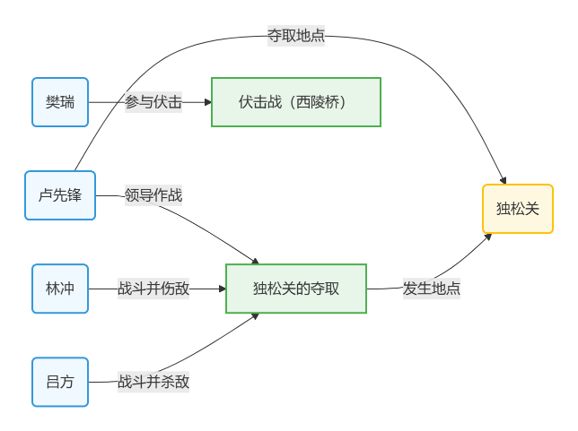

"relationship" 的表示：

"relationship" <|> 实体1 <|> 实体2 <|> 关系描述

上述形式可以抽象出 ("实体A", "关系", "实体B") ，通过该元组即可构建知识图谱的结构：节点（实体）+ 边（关系）

例如：

"relationship"<|>"卢先锋"<|>"独松关的夺取"<|>"卢先锋领导军队成功地取下了独松关……

通过这行表示即可建立实体“卢先锋”与实体“独松关的夺取”之间的联系。

另外，对 “卢先锋”的消歧是通过其他片段的提取，完成了关联。

```bash
<node id="&quot;卢先锋&quot;">
  <data key="d0">"PERSON"</data>
  <data key="d1">"卢先锋在军事行动中发挥领导作用，指挥军队进攻，并在军事行动后进行奖励。"&lt;SEP&gt;"卢先锋是军队中的指挥角色，负责决策和指挥军事行动。"&lt;SEP&gt;"卢先锋是前线的军事指挥团队，攻破晋宁，并赢得了对
阵孙安的战斗。"&lt;SEP&gt;"卢先锋是宋军的指挥官，指挥军队攻占昱岭关并获得关键胜利。"&lt;SEP&gt;"卢先锋是宋江手下的将领，曾接待孙安，并派遣孙安前往壶关探听消息。"&lt;SEP&gt;"卢先锋是宋江手下的将领，被派遣去攻打湖>州。"&lt;SEP&gt;"卢先锋是晋宁的指挥官，戴宗前往晋宁探听军情的对象。"&lt;SEP&gt;"卢先锋是梁山泊的好汉之一，被贺统军围困。"&lt;SEP&gt;"卢先锋是这场战役中的重要指挥官，负责制定策略和指挥战斗。"&lt;SEP&gt;"卢先锋率领
军队取下了独松关，在独松关与敌人激战。"</data>
  <data key="d2">chunk-70d484f8faf2a52a92c82011634f06dc&lt;SEP&gt;chunk-52ed314b18da8a382391ebd05c40a624&lt;SEP&gt;chunk-e054d9d89262c9af698db2a0121d5acc&lt;SEP&gt;chunk-09a8db8ba347c7b7bc0176d4525c0cf2&lt;SEP&gt;chunk-f7436d476ba11775cbffaaaec7258ed9&lt;SEP&gt;chunk-fe76f7b689672053ec6306a05f0cdd0b&lt;SEP&gt;chunk-0626d86fb637457aed588a314f92803a&lt;SEP&gt;chunk-5dccdbae178f7538ee5e466f932be0dc&lt;SEP&gt;chunk-71fb5004c46bc9c5d7428068a57a02e0&lt;SEP&gt;chunk-75d67bf231332d5355799af8db0ae8e3</data>
</node>

<!-- "副先锋"是个孤立实体，最终知识图谱中无任何关联实体 -->
<node id="&quot;副先锋&quot;">
  <data key="d0">"ROLE"</data>
  <data key="d1">"副先锋是指卢俊义的职务，他担任的职务仅次于宋先锋，负责同样重要的军事任务。"&lt;SEP&gt;"卢俊义担任的职位，负责与宋江一起执行军事行动。"</data>
  <data key="d2">chunk-8be99d60dd263a48610af8a66041938b&lt;SEP&gt;chunk-06d94d584d8549b7f59105730610e475</data>
</node>

<node id="&quot;卢俊义&quot;">
  <data key="d0">"PERSON"</data>
  <data key="d1">卢俊义，绰号玉麒麟，是大名府的长者和富豪，以高超的武艺尤为擅长棍棒技巧而闻名。在梁山泊中，卢俊义与宋江并列成为重要将领，经常担任先锋的角色。他曾独自抵抗四个番将并斩杀耶律宗霖，也参与多次军事行动>，如攻打蓟州和檀州。被任命为副先锋，卢俊义不仅负责领导军队攻击多个城市，包括宣州、湖州等地，同时也负责执行宋江下达的各项军事任务。在平定各城市的过程中，卢俊义展现出了英勇的战斗能力及杰出的统帅才能。作为宋江的重要
副手，卢俊义不仅指挥中军，还与其他好汉一起商讨战略，且亲自领兵发起攻击以破坏敌军。不仅参与军事行动，卢俊义还协助宋江处理招安事宜，并在对抗辽国的侵扰中扮演关键角色。此外，他亲自带领军队突破昱岭关，进攻歙州等重要行
动，展现了其军事才能和领导才能。在战斗中，卢俊义虽然遭遇了多次挫折，如曾经历多次军事行动的挫败，但仍作为梁山泊重要的军事指挥官，与宋江一同指挥军中事务，最终为梁山泊的归顺朝廷作出了重要贡献，成为梁山泊的关键领导人
之一。然而，在故事的最终章，卢俊义因坠入淮河而死去，这一事件进一步深化了故事的发展。卢俊义不仅被皇帝册封，曾担任兵马副总管、平南副先锋等职务，也积极参与出征和保境安民的行动，展示了他的非凡领导才能和军事能力。</data>
```

```bash
<edge source="&quot;天子&quot;" target="&quot;卢俊义&quot;">
  <data key="d3">9.0</data>
  <data key="d4">"天子任命卢俊义为副先锋。"</data>
  <data key="d5">"任命,信任"</data>
  <data key="d6">chunk-06d94d584d8549b7f59105730610e475</data>
</edge>

<edge source="&quot;卢俊义&quot;" target="&quot;卢先锋&quot;">
  <data key="d3">8.0</data>
  <data key="d4">"卢俊义作为卢先锋，统领军队进攻玉田县。"</data>
  <data key="d5">"军队指挥, 战略推进"</data>
  <data key="d6">chunk-a7949e3833d3220bc3a90adf93e855f8</data>
</edge>
```

### RAG如何使用知识图谱召回

知识图谱检索的目标是根据用户的查询，返回相关的实体、关系或路径，以提供精准的答案。用户查询往往是文本形式，因此要在知识图谱中获取相应的知识，需要先对用户查询进行解析并提取相关实体和关系。例如用户提问“牛顿发现了什么？”，这是应该解析出实体“牛顿”和对应的关系“发现”，然后在知识图谱中查找与“牛顿”相关的关系。具体来说，查询会转化为一组图的路径或子图的匹配，系统通过搜索与查询中实体和关系相匹配的节点和边，获取相关的子图。除了简单的子图匹配外，在一些复杂的查询中，可能还需要进行路径搜索，即从一个实体出发，沿着关系边遍历图，找到与查询相关的其他实体。例如，如果查询是“爱因斯坦和牛顿的关系是什么？”，系统可能需要从“爱因斯坦”和“牛顿”出发，沿着图中的关系（如“影响”、“继承”）找到它们之间的联系。

其流程如图3 所示：

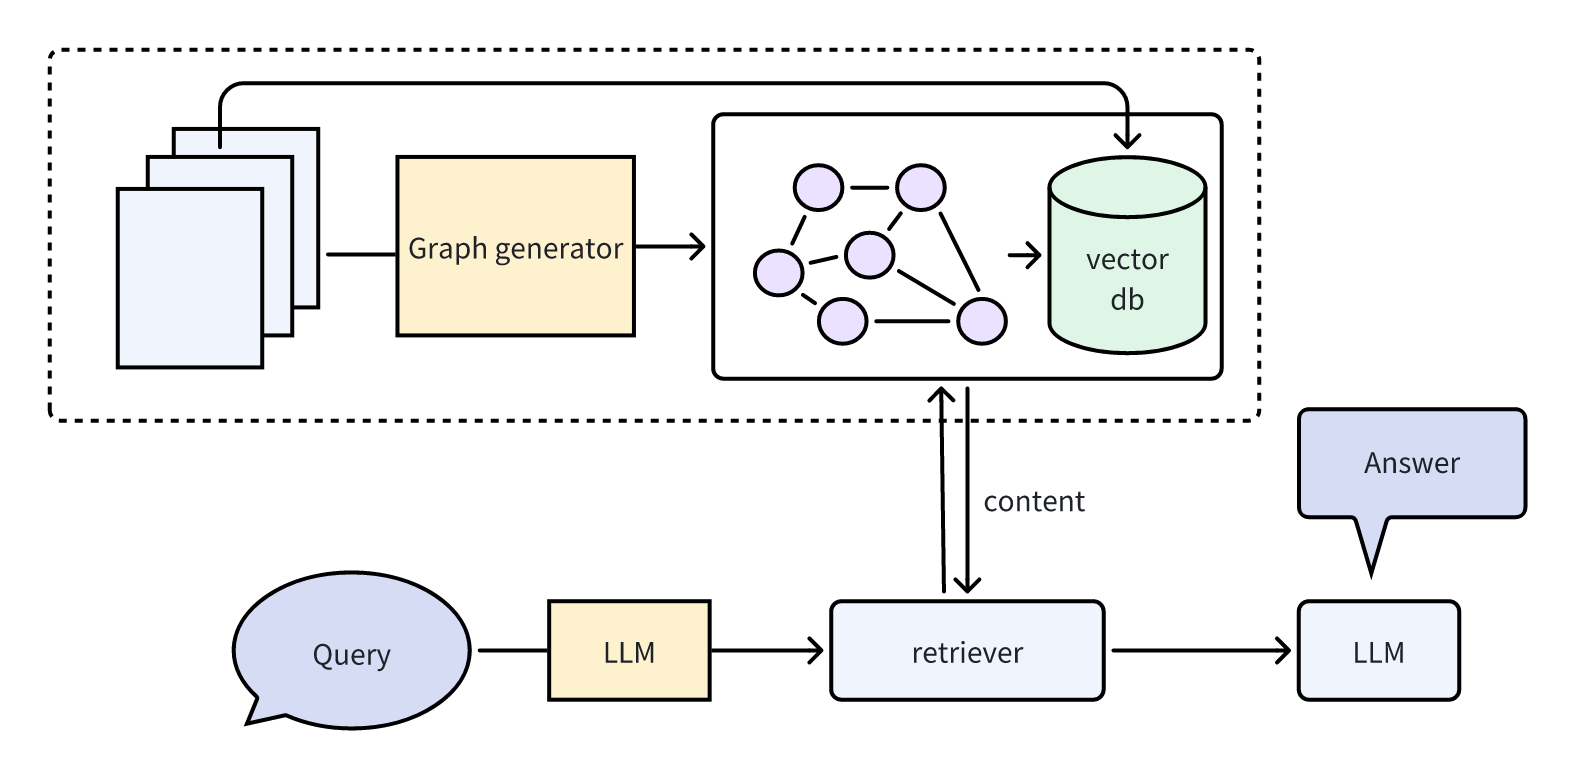

图3 Knowledge Graph Based RAG 流程示例

基于知识图谱的RAG系统回答过程包括以下步骤：首先，在检索阶段，根据用户输入问题从知识图谱中召回相关的实体、关系以及原文内容；接着，在增强阶段，将召回的结构化结果整合为额外的上下文信息，与用户输入一起提供给大模型，以增强其理解和推理能力；最后，在生成阶段，系统通过大模型生成答案，该过程与朴素RAG系统一致。

# **知识图谱增强型RAG的优势**

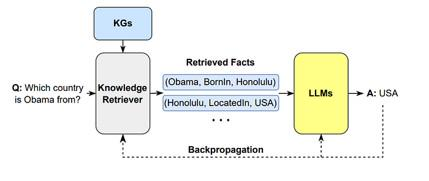

**增强可解释性和推理能力**

知识图谱是结构化的，天然适合组织分散的非结构知识，使检索更具可控性与解释性。

**高可扩展性，低成本更新**

图谱动态更新，不依赖重新训练语言模型

**动态知识融合**

知识可视为大型语言模型 可访问的动态数据库，用于查询最新相关信息。这些知识与 LLM 的集成是通过高级架构实现的，从而促进了文本标记与知识图谱实体之间的深度交互。

## **开源实现：两大知识图谱RAG系统解析GraphRAG与LightRAG**

Knowledge Graph Base RAG 实现方式上目前有两款知名的开源方案 GraphRAG 与 LightRAG

### GraphRAG

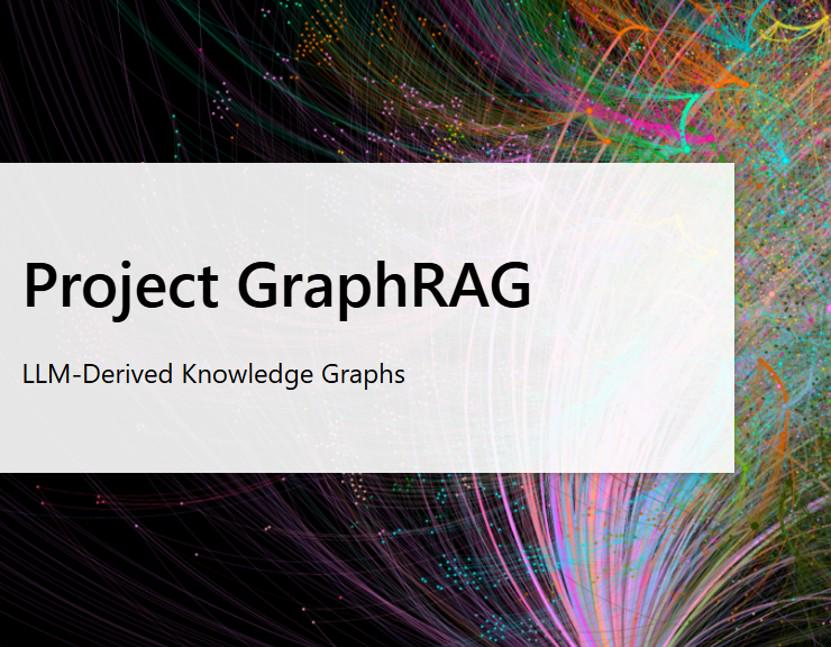

GraphRAG通过构建知识图谱和分层社区结构，将局部信息聚合为全局理解。其核心优势在于：利用LLM从文档中提取实体、关系和事实声明构建知识图谱，通过图结构索引捕捉语义关联；通过分层社区检测，使用图社区算法将图谱划分为紧密关联的社区，递归生成从局部到全局的摘要；采用Map-Reduce式回答生成方法，借助社区摘要的并行处理与聚合，生成全面且多样的全局回答。

**GraphRAG工作流程**

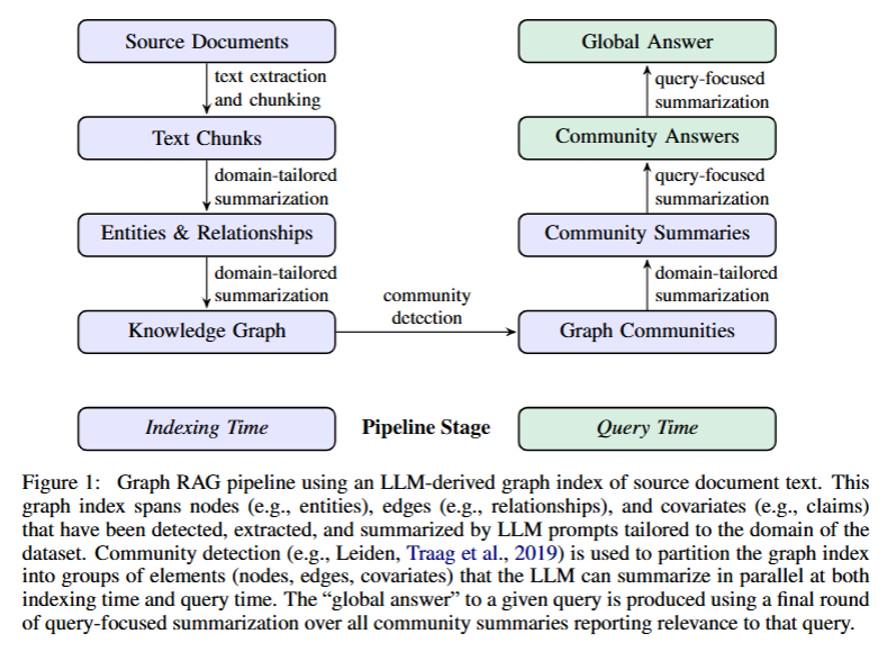

GraphRAG通过以下流程实现从文档到全局回答的生成：首先，将文档拆分为文本块，并使用LLM提取其中的实体、关系及事实声明；接着，基于提取结果构建知识图谱，将实体和关系转化为图节点和边，对重复实例进行聚合并生成节点描述，同时根据关系出现频率设定边的权重。然后，利用Leiden算法对图谱进行递归划分，形成嵌套的社区结构，每个社区代表一个语义主题，构建从局部到全局的层级结构。社区摘要生成阶段中，叶社区按节点重要性排序，聚合其中的实体、关系和声明生成摘要，而高层社区则通过递归整合子社区摘要，平衡细节与全局视角。在查询处理与回答生成阶段，系统根据用户问题对每个社区摘要独立生成部分回答，并通过评分过滤无关内容，最终聚合高分回答生成全面且准确的全局回答。

微软 GraphRAG 在知识图谱的基础上增加了一个社区(Community)的概念。

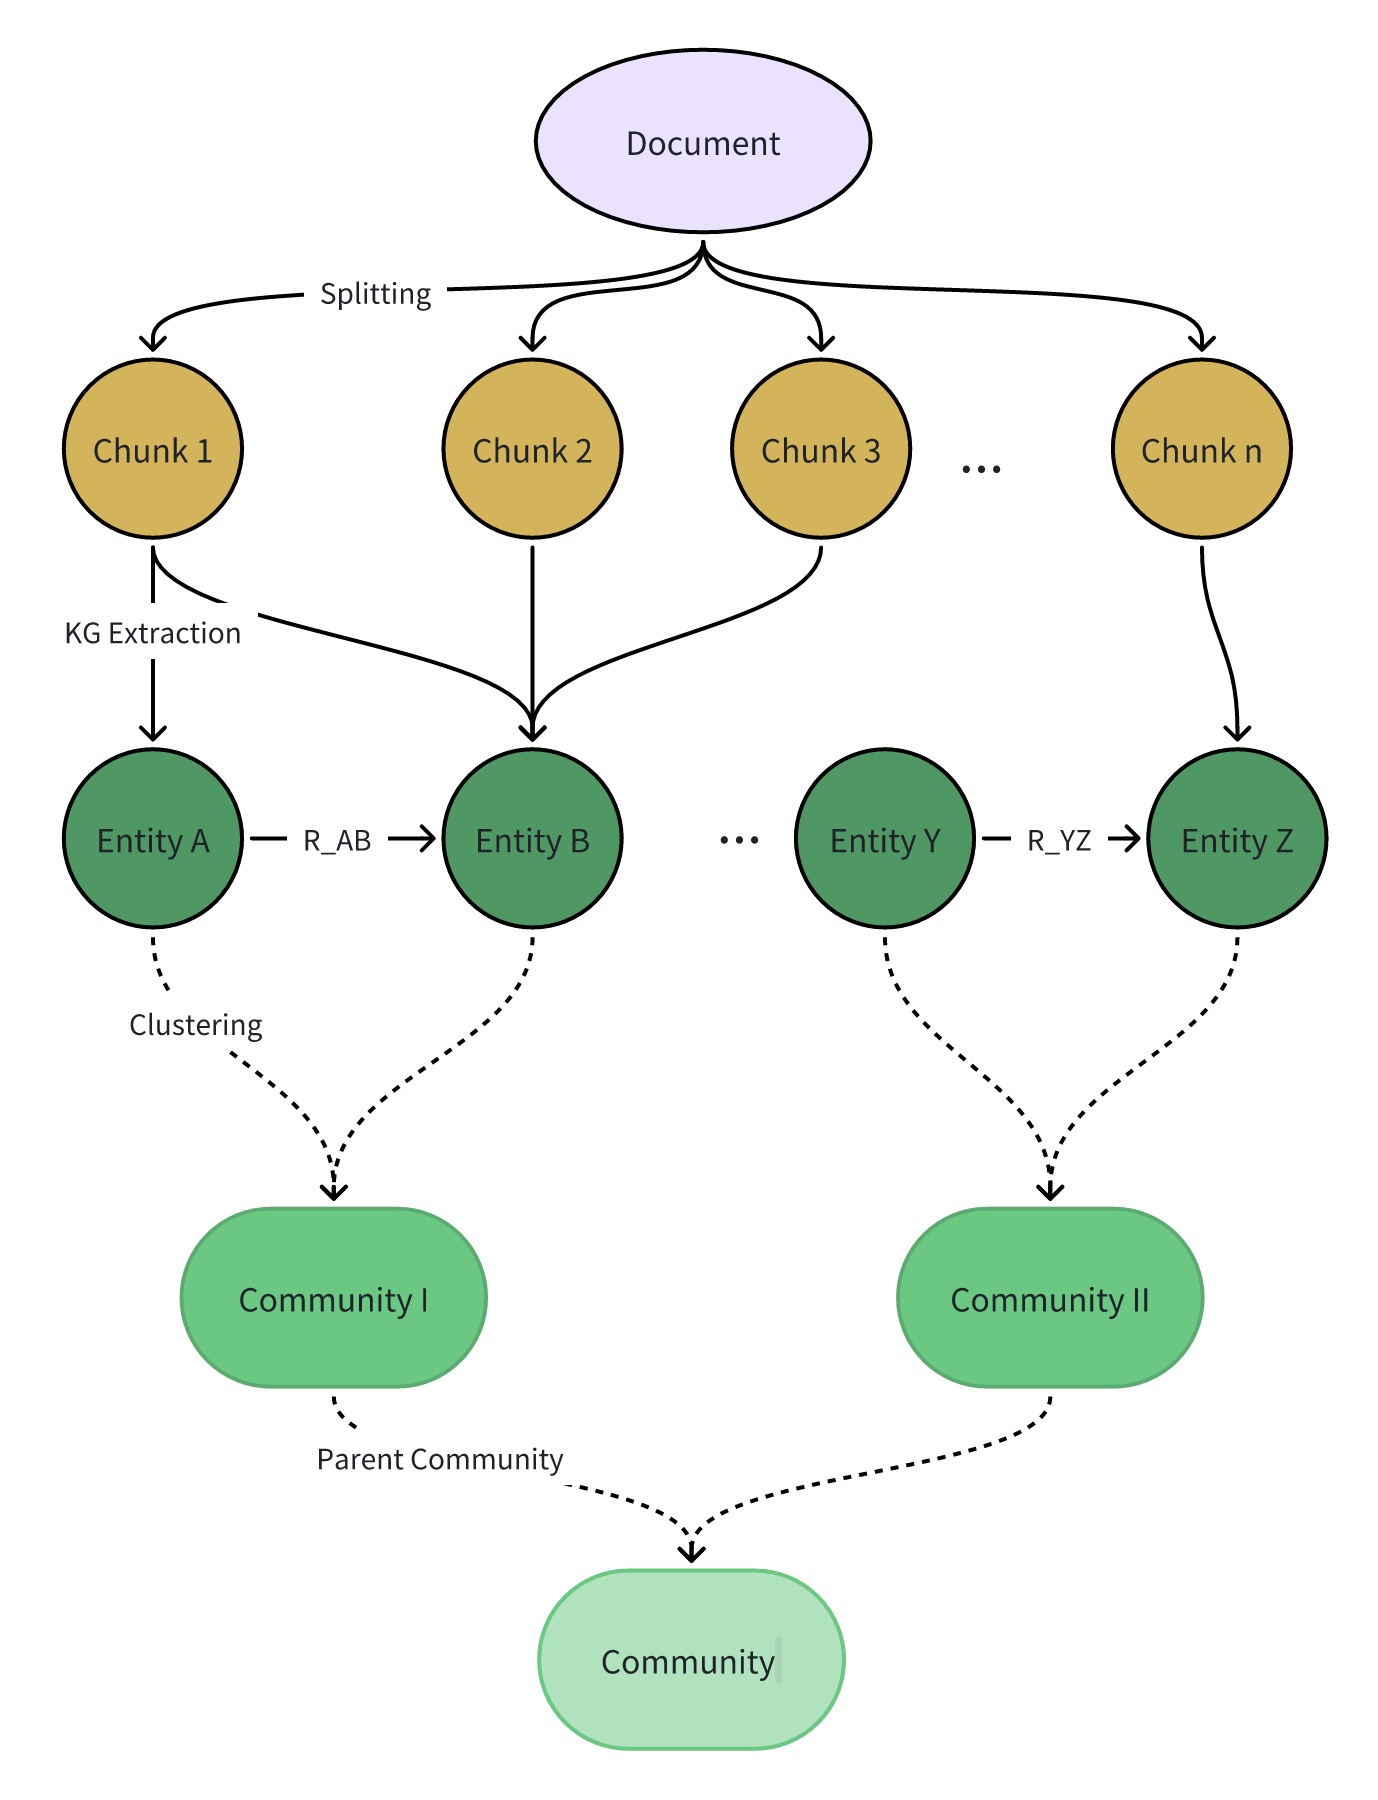

社区是 GraphRAG 中的高级结构，表示一组相关实体的集合。每个社区包含以下字段：

```bash
ID：社区的唯一标识符。
Level：社区的层级（如 0、1、2 等）。
Entity IDs：社区中包含的实体 ID 列表。
Relation IDs：社区中包含的关系 ID 列表。
Text Block IDs：社区中包含的文本块 ID 列表。
Description：社区的描述信息。
Summary：社区的摘要信息。
```

GraphRAG 在是构建Knowledge Graph后，增加了一个社区摘要（Community Summaries）的生成环节。这一策略使得系统在检索时只关注与查询高度相关的社区，而不是检索整个图。社区摘要对数据全局结构和语义的高度概括,  即使没有问题,  用户也可以通过浏览不同层次的社区摘要来理解语料库。

社区摘要生成由两步组成：

1. 社区检测：使用图分析算法，获得具有高度连接性的实体簇
2. 摘要提取：使用LLM根据社区中的实体和关系，提取各类型总结。

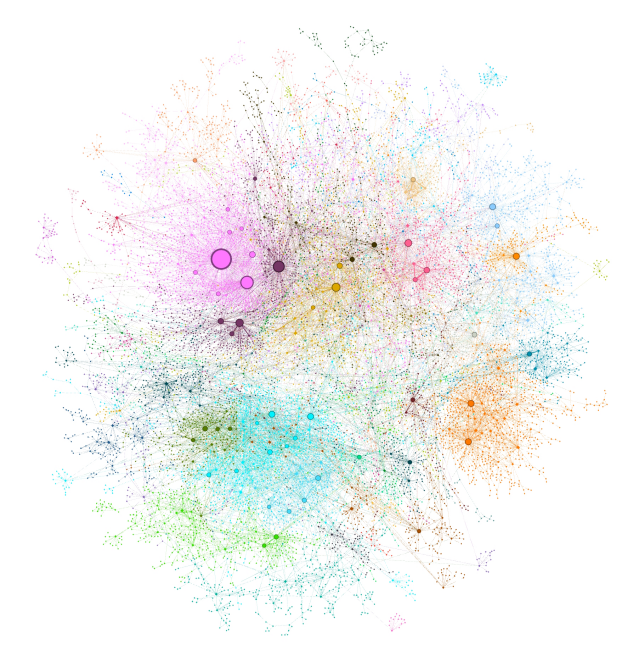

图5 微软 Graph RAG 的社区聚类效果图

图5 展示了微软 Graph RAG 在社区聚类后生成的可视化图示例，不同颜色代表不同的社区，每个社区都有对应的摘要。在这种知识图谱中进行检索时，除了直接匹配新型实体和关系，或利用推理获取信息外，还需要考虑知识的层次结构。微软 Graph RAG 针对其层次结构提出如下三种检索方法：

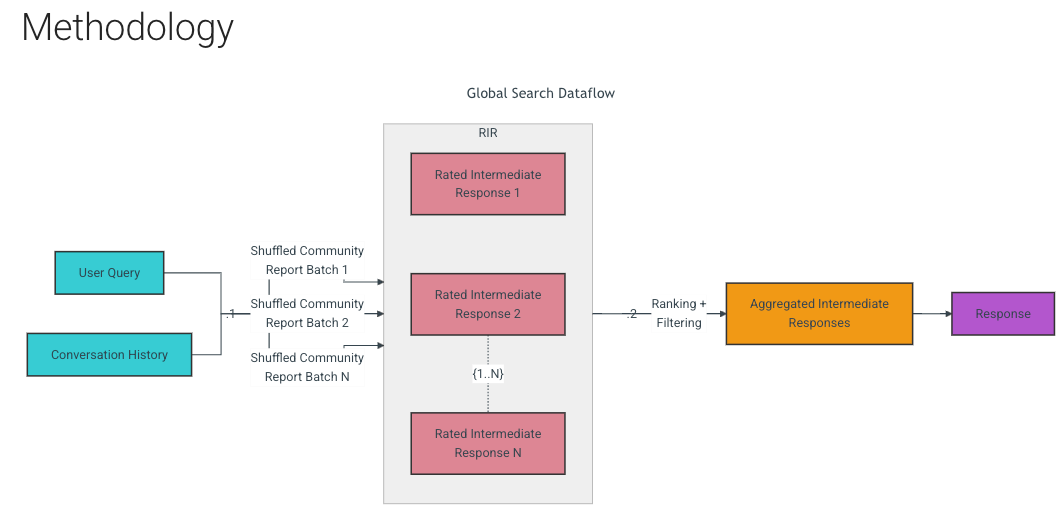

​**全局搜索**（**Global Search**）​：采用Map-Reduce 方式，在所有由 AI 生成的社区摘要中进行搜索并生成答案。这种方法消耗较多资源，但对于需要整体理解数据集的问题（例如：“该笔记中提到的草药最重要的价值是什么？”），通常能够提供更优质的回答。在给定用户查询的情况下，全局搜索方法利用来自指定层级的社区层次的LLM生成社区摘要作为上下文数据，以 map-reduce 方式生成响应。在 map 步骤中，社区摘要被分割成预定义大小的文本片段，每个文本片段用于生成一个包含要点列表的中间响应，每个要点附带一个数值评分，表示其重要性。在 reduce 步骤中，从中间响应中筛选出最重要的要点并进行聚合，以此作为上下文来生成最终的用户响应。全局搜索的响应质量受到所选社区层级的影响，较低的社区层级提供更详细的报告，通常能生成更深入的响应，但由于报告数量较大，也可能增加最终响应的生成时间和LLM计算资源的消耗。

Global Search更侧重于回答全文摘要总结类的场景，比如：“请帮我总结一下这篇文章讲了什么内容？”。

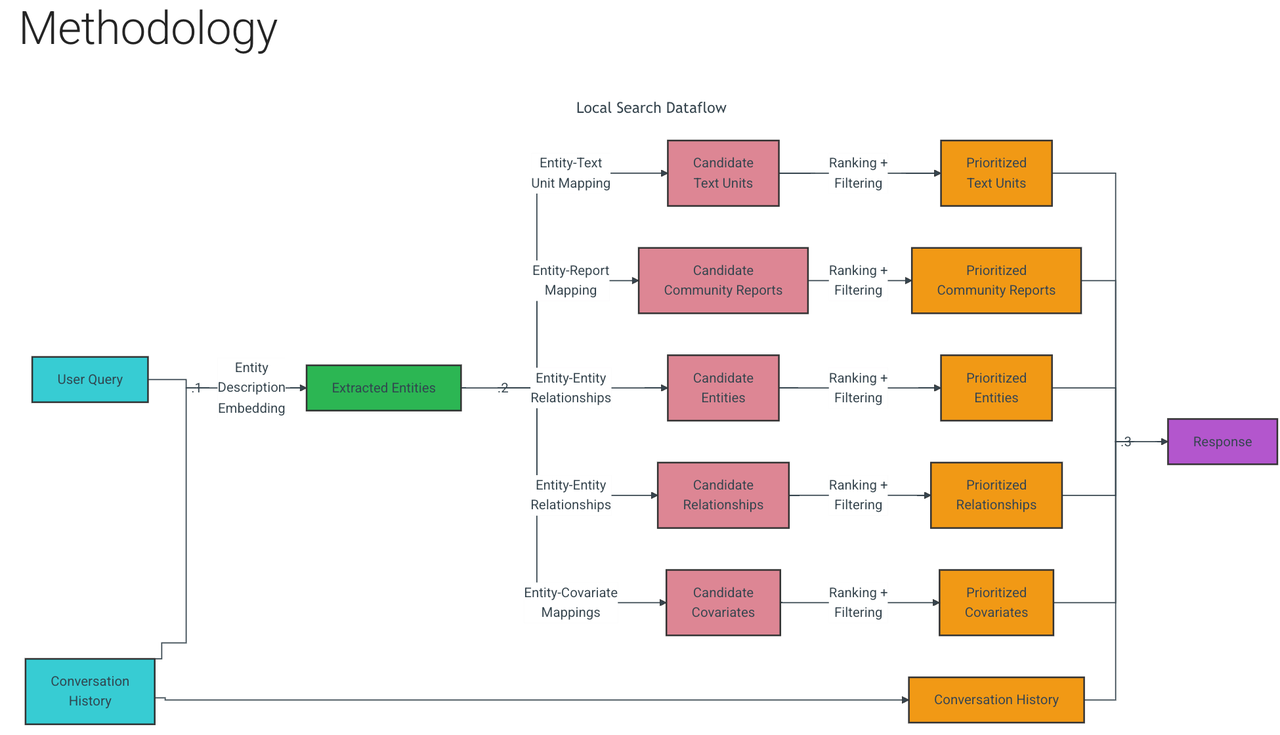

​**局部搜索**（**Local Search**）​：通过结合知识图谱与原始文档的文本片段来生成答案，特别适用于需要理解文档中特定实体的问题，例如：“洋甘菊有哪些治疗功效？”。在给定用户查询的情况下，局部搜索方法会从知识图谱中识别出与用户输入在语义上相关的一组实体。这些实体作为访问知识图谱的入口，帮助系统提取更多相关细节，如连接的实体、关系、实体协变量以及社区摘要。此外，该方法还会从原始输入文档中提取与识别出的实体相关的文本片段。然后对这些候选数据源进行优先排序和筛选，以适应一个预定义大小的单一上下文窗口，用于生成对用户查询的响应。

局部搜索适用于需要理解文档中提及的具体实体的特定问题，例如：洋甘菊具有哪些疗效？

​**DRIFT Search**​（Dynamic Reasoning and Inference with Flexible Traversal）是一种结合Global Search和Local Search的方案。其搜索过程分为三步

1. 社区报告检索：DRIFT 将用户的查询与语义最相关的前K个社区报告进行比较，生成广泛的初步答案和后续问题以引导进一步的探索。
2. 相关数据提取：DRIFT使用本地搜索来优化查询，生成额外的中间答案和后续问题以增强特异性，从而引导搜索引擎获取更丰富的上下文信息。
3. 相关性排序：最后则是根据相关性对相关节点进行排序，并将排序后的文档作为上下文信息输入到LLM，生成最终的响应。

### Light RAG

LightRAG的知识图谱是比较基础的 分片+实体/关系

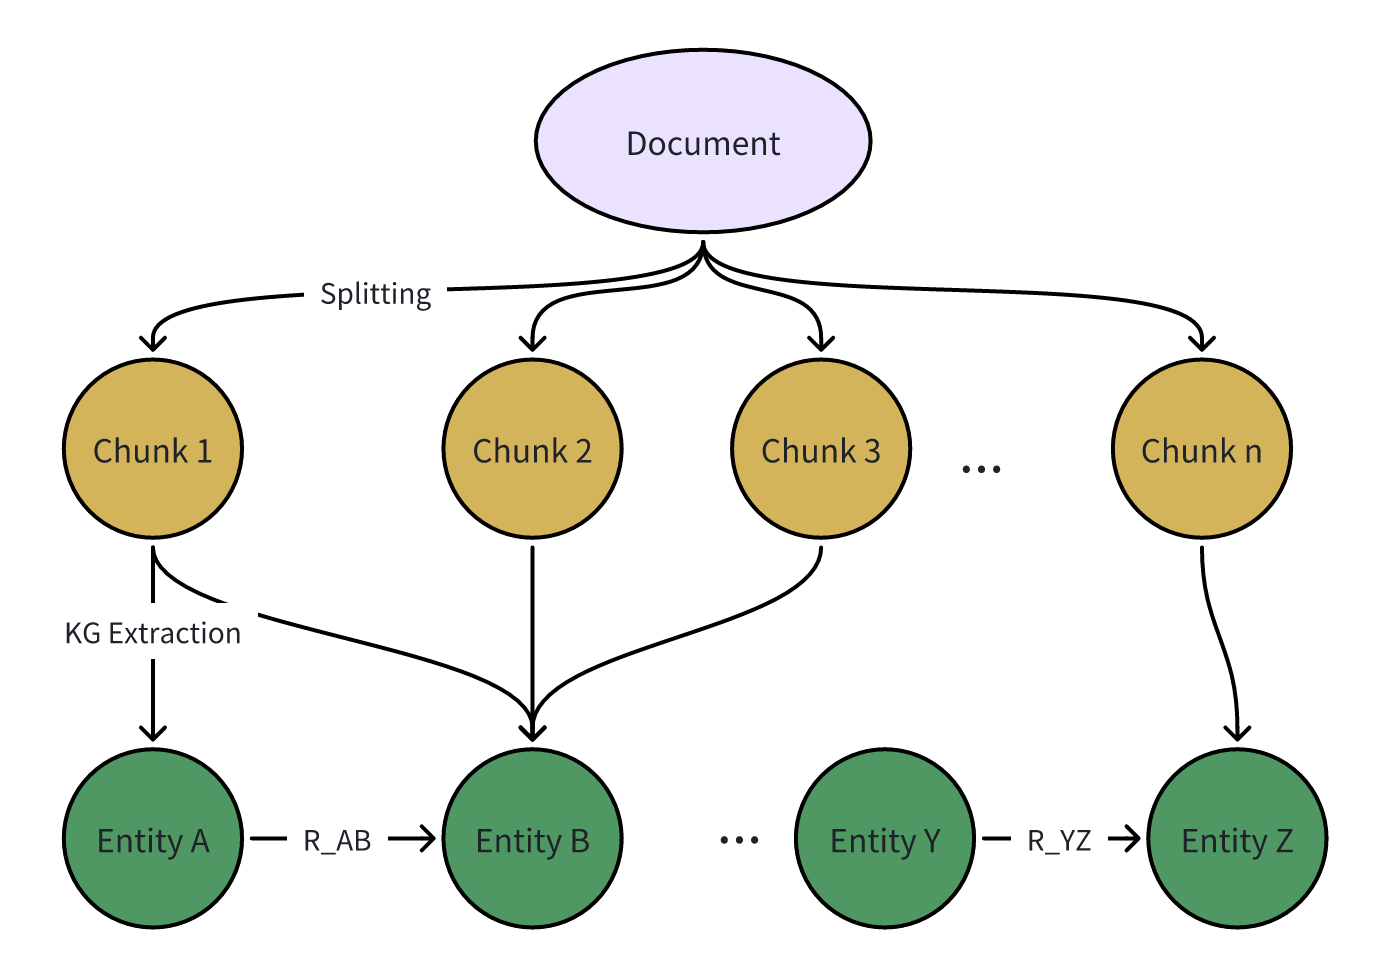

微软 GraphRAG 在处理全局或高层级概念查询方面表现优越，具备较强的可扩展性，并通过图索引提供更好的上下文理解和可解释性。然而，其运行速度较慢，依赖大量 LLM API 调用，可能触及速率限制且成本高昂。例如，使用 GPT-4o 索引一本 32K 单词的书可能需花费 6-7 美元。此外，添加新数据需要重建整个知识图，效率低下，并且缺乏去重机制，可能导致索引冗余和噪声增加。

对于Legal Dataset，共94篇文章，约5000K Token（约5个水浒传大小）。GraphRAG 生成了 1399 个communities，平均每个社区报告生成需要5000Token, 其中 610 个 level-2 communities， 平均每个level-2的社区占用1000Token。下表对比了创建知识图谱和一次检索所消耗的LLM Token。C\_Max为API单次请求最多Token限制，T\_extract 代表提取实体和关系消耗Token数，C\_extract则表示提取产生的API调用次数。

注：GraphRAG 从0.4.0开始支持增量索引。

| 处理阶段       | 方案       | Token 消耗                  | API 调用次数               |
|----------------|------------|-----------------------------|-----------------------------|
| query-召回     | GraphRAG   | 610 * 1000                  | 610 * 1000 / C_Max          |
|                | LightRAG   | < 100                       | 1                           |
| 文档创建（5000K Token） | GraphRAG   | 1399 * 5000 + T_extract     | 1399 + C_extract            |
|                | LightRAG   | T_extract                   | C_extract                   |


LightRAG 是一种轻量级的知识图谱RAG，它没有使用层次化的社区聚类，而直接构造了知识图谱，从而支持了增量更新，无需每添加一部分数据都需要进行实体和关系的提取。由于使用了无关层次的图谱结构，在检索方面也采用了新的方法。LightRAG 采用了双层检索策略，包括低层级检索（集中关注特定实体的信息）和高层级检索（处理更广泛的主题），这种设计能够在不进行社区层次聚类的基础上有效地检索相关实体及其关系，从而提高检索的全面性和响应的上下文相关性。

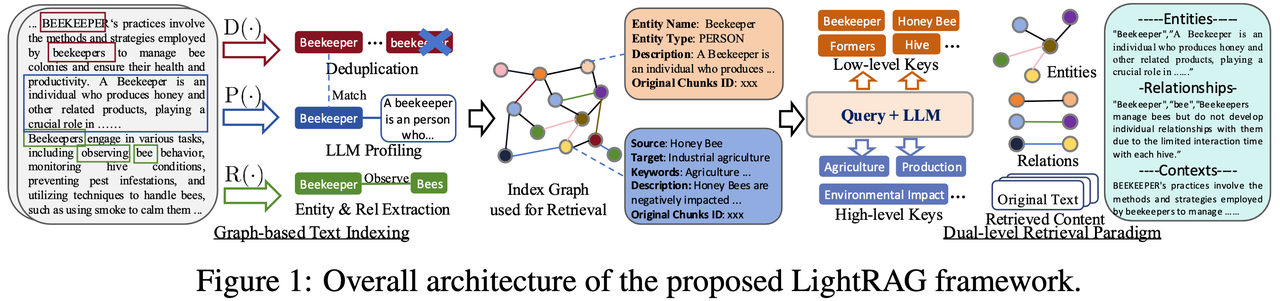

图 6 LightRAG 整体结构（图源 LightRAG 论文）

具体来说 LightRAG 对文档进行实体和关系抽取，在这一步完成后进行去重操作，然后进行图索引，即构建知识图谱。构建好的知识图谱如图6 中间位置所示，每个节点有（Entity Name，Entity Type，Description，Original Chunk ID）几个属性，而每条关系都有（Source，Target，Keyword，Description，Original Chunks ID）几个属性。当系统接收到用户消息时，首先通过 LLM 提取具体（Specific）和抽象（Abstract）两个层次的关键词，其中具体关键词关注实体的具体信息，即实体名称、实体类型等，而抽象关键词则更关注问题所涉及的主题或领域等高层级信息。提取了这些关键词之后对前一步构造的知识图谱进行检索，具体来说使用具体关键词进行低层级检索获得相关实体和概念，使用抽象关键词进行高层级检索获得宏观主题或趋势等信息，最终 LLM 接收相关实体、关系以及原文文档作为上下文，对用户问题给出答案。此后新数据加入时，仅需更新新增的图节点和边，无需重建整个索引，大幅降低计算开销。

LightRAG 引入的高层级检索和低层级检索关注不同层次内容：

低层级检索（Low Level Retrieval）: 专注于提取特定实体及其关联的属性，旨在提供关于图中特定节点或边的精确信息。当系统发起查询时，低层级检索方法会基于图数据库中的节点和边，生成包含详细属性和关系的上下文数据，以辅助响应生成。例如图6 中提取的低层级关键词包括“beekeeper”，“hive”等非常精确具体的词语，通过这些关键词对图进行检索时对应的实体名称或实体的属性信息，为 LLM 提供细节信息。

高层级检索（High Leval Retrieval）：面向宏观主题与整体趋势，侧重于跨多个关联实体和关系进行信息聚合，以提供综合性见解。在检索阶段，系统会基于用户查询，从图数据库中筛选与主题相关的实体集合，并聚合它们之间的多维度关系，生成上下文数据作为响应依据。图6 中提取的高层级关键词有 “agriculture”，“production”等非常抽象且高级的概念，这些内容需要通过结合实体与关系进行检索甚至相关推理才能给出完整的答案，与低层级检索相比，高层次检索可以为 LLM 提供更高层次的主题内容。

High Level Retrieval Example

**`林冲的主要事迹有哪些？`**​**​ ​**

```bash
hl_keywords: 0 ='林冲', 1 ='主要事迹', 2 ='人物形象'
```

* Step2: 向量库召回相关Relation (top-k :60)

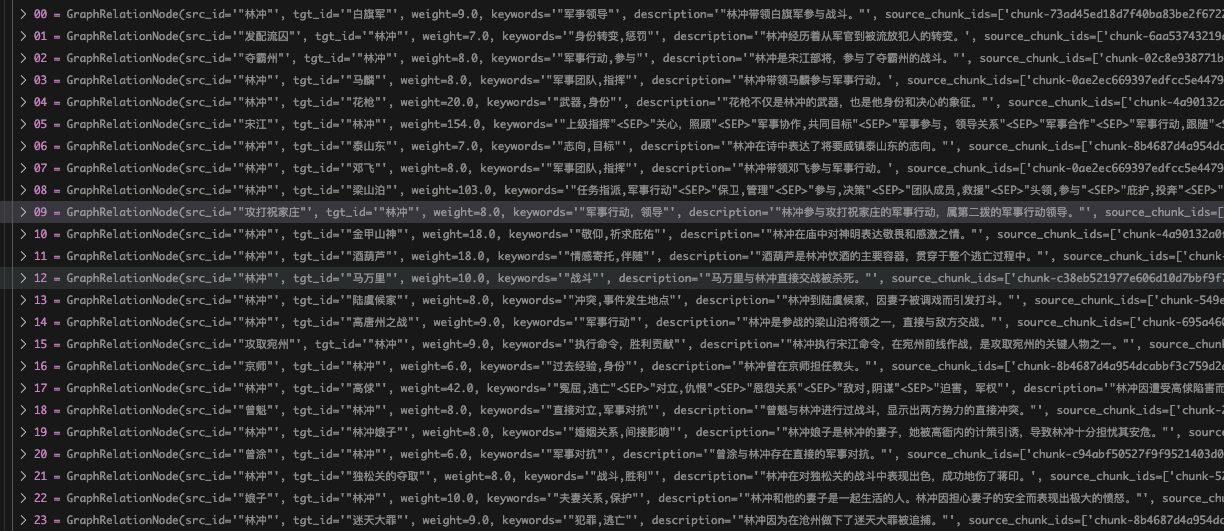

* Step3: 由候选Relation扩展到候选Entity

  依Relation的召回顺序取出src\_id和tgt\_id对应的实体并去重，并根据设置的max\_token进行截断
  
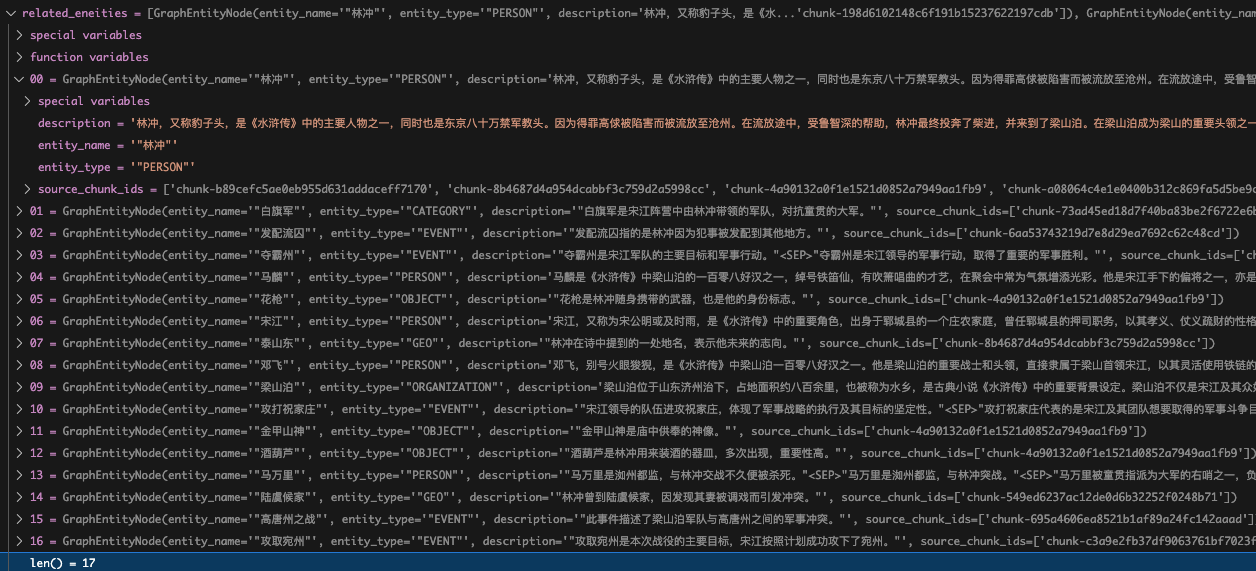

* Step4: 候选Relation扩展到候选Chunk

  依Relation的召回顺序取出chunk\_id对应的chunk并去重，并根据设置的max\_token进行截断。

* Step5: 将召加的 Enitity(name, type, description), Relation(src_name, target_name, keywords, description), Chunk   (content) 拼接为context_str，作为RAG的召回知识

* Step6: LLM 生成回复

```bash
  1. 身份转变：林冲原是东京八十万禁军的枪棒教头，因得罪高俅被陷害而被流放至沧州。在流放途中，受鲁智深的帮助，最终投奔了柴进，并后来加入了梁山泊。
  
  2. 加入梁山泊：林冲因遭受高俅的迫害而被迫逃离京城，寻求庇护于柴进处。之后，他前往梁山泊并成为梁山的重要头领之一。他还协助推翻了原来的首领王伦，立晁盖为新的领导人。
  
  3. 军事行动：
     - 参与攻打祝家庄的军事行动，作为第二拨的军事行动领导。
     - 在高唐州之战中直接与敌方交战。
     - 执行宋江命令，在宛州前线作战，是攻取宛州的关键人物之一。
     - 参与迎战辽国援军的战斗。
     - 在独松关的战斗中表现出色，成功地伤了蒋印。
  
  4. 个人英勇表现：
     - 林冲多次在重要战役中展现了他的英勇和忠诚，与多位将领如关胜、王焕以及贺统军等对决，并取得了显著的战绩。
     - 他参与了多次军事行动，包括寻找卢俊义、护送宿太尉进辽国颁诏和计划参与对辽国军队的攻击等。
  
  5. 患病与疗养：林冲后来染患风病瘫痪，留在六和寺中休养。
  
  6. 忠诚与影响力：尽管在面对招安时内心有所质疑，但林冲对梁山泊的贡献和在英雄中的地位是无可替代的。他的英勇和忠诚在《水浒传》中留下了一段传奇。
  
  这些事迹展示了林冲从一名禁军教头到成为梁山重要头领的过程，以及他在多次战斗中的英勇表现和重要作用。
```

LightRAG 相比 GraphRAG 在提升查询效率和降低计算成本方面具有显著优势。它通过直接构建知识图谱和支持增量更新，解决了 GraphRAG 在数据更新和处理速度上的不足。同时，双层检索策略使得 LightRAG 在不依赖复杂社区层次聚类的情况下，能够高效且全面地检索相关实体和关系，进一步提高了结果的上下文相关性和精确度。这些优势使得 LightRAG 成为一种更加高效、灵活且成本可控的解决方案。

不足：

1. 创建知识图谱对提取效果要求较高，实际体验线上模型好于单机开源模型，因此有一定成本。注：本节示例创建知识库使用的Qwen2.5-32B，生成时使用的线上模型 Qwen2.5-Max。
2. LightRAG/GraphRAG 中Chunk 以List形式合并入实体和关系。一般关系（边）的合并情况不多，但对于类似小说角色这样的实体（点），其出现频率高，相关chunk非常多，当以实体为中心(low level retrieval)召回实体，继而召回相关原文片段时，无法对实体内的Chunk进行细分排序。比如“林冲”这个实体下有140+个 chunk，其无法在实体召回后排序内部chunk相关度，结果就是根据MAX\_TOKEN配置被截断的chunk其实上相关度不高。

## **选型决策树：你的问题需要哪种RAG？**

向量检索和图检索各自具有独特的优势，适用于不同类型的任务。朴素RAG通过向量检索的方式，能够快速、有效地匹配相关文本片段，特别适用于处理大量非结构化文本数据时，能够迅速从大规模数据中提取关键信息。

然而，面对涉及复杂实体关系和多层次上下文理解的任务时，图检索则展现了其独特的优势。GraphRAG通过构建知识图谱，能够在查询过程中深入理解实体之间的关系，提供更为丰富和准确的上下文支持，确保查询结果的完整性和关联性。

因此，目前也有基于混合检索的 RAG 系统，结合了向量检索和图检索的优点，使得两者在任务中的互补性得以充分发挥。结合这两种技术，可以在处理简单查询时借助向量检索的高效性，而在复杂的多层次查询中依赖图检索提供深度的语义理解。根据具体任务的需求选择合适的检索方法，可以显著提升问答系统的整体性能，确保生成结果的高质量与准确性。

## **实战与案例分析：知识图谱RAG对复杂query的提升**

注：NaiveRAG的实战在第2-7章节中已做过介绍，在此不额外赘述

### LightRAG实战

**配置**

* Dataset:

水浒传\_utf8.txt  （约912K Tokens)

* 切分及召回

NaiveRAG  Chunk 1200 Token; top\_k: 10

LightRAG Chunk 1200 Token ;  relation/entity top\_k: 60

#### 使用LightRAG构建知识图谱

* Step 0: 环境准备

vLLM

```bash
pip install vllm
```

LightRAG

```bash
pip install lightrag-hku
```

infinity

```bash
pip install infinity-emb
```

LazyLLM

```bash
pip3 install lazyllm
```

* Git clone https://github.com/HKUDS/LightRAG 并安装lightrag `pip install "lightrag-hku[api]"`

* 下载语料 `水浒传.txt` 转为 utf8，并重命名放入比如`"novel/shuihu.txt"`

* 主动创建保存知识图谱的目录

* Step 1: 使用VLLM/Ollama等工具部署openai 兼容格式的LLM服务

注：由于文章较长，尝试过多个平台的在线模型，即使换不同的语料，依然会有触发“内容安全限制”的情况。所以只能选择本地部署的LLM。

下载模型(Qwen 2.5-32B-Instruct)，推荐从ModelScope下载

```bash
python -m vllm.entrypoints.openai.api_server --model /mnt/lustre/share_data/lazyllm/models/Qwen2.5-32B-Instruct/ --served-model-name qwen2 --max_model_len 16144 --host 0.0.0.0 --port 12345
```

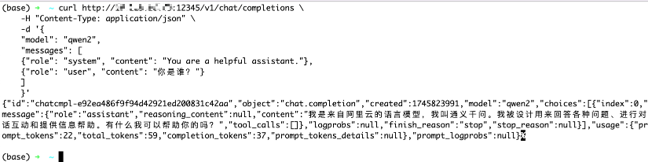

* Step 1-2: 部署embedding 服务或使用已有平台的openai兼容格式的embedding在线服务

下载模型(bge-large-zh-v1.5)，推荐从ModelScope下载

```bash
infinity_emb v2 --model-id "/mnt/lustre/share_data/lazyllm/models/bge-large-zh-v1.5" --port 19001 --served-model-name bge-large
```

测试一下服务

注：vLLM启动的服务对应的openai格式的base\_url为 : http://{ip}:{port}， 若用curl测试则url为 http://{ip}:{port}/embeddings

curl --location 'http://127.0.0.1:19001/embeddings' --header "Authorization: Bearer TEST" \\

--header 'Content-Type: application/json' --data '{

"model": "bge-large",

"input": "基于知识图谱的RAG系统",

"dimension": "1024",

"encoding\_format": "float"

}'

* Step 2: 参照 examples/lightrag_openai_compatible_demo.py 修改LLM服务和embedding服务的配置

配置llm_model_func和embedding_func 的三个参数：model, base_url, api_key

  1. 设置处理的文件名和保存知识图谱的文件夹路径

      WORKING_DIR 为 知识图谱保存的文件夹路径

      PATH_TO_TXT 为 待解析的小说 <水浒传>，注意检查是否为utf8格式

  2. 修改llm_model的配置

      base_url 改为  http://{ip}:{port}/v1

      model_name 改为 vLLM中配置的 qwen2

  3. 修改openai_embed的配置

      base_url 改为  http://{ip}:{port}

      model_name 改为 infinity中配置的 bge-large

[代码GitHub链接](https://github.com/LazyAGI/Tutorial/tree/main/rag/codes/chapter19/lightrag_data_to_kg.py)

In [ ]:
async def main():
    WORKING_DIR = "****"
    PATH_TO_TXT = "shuihu.txt"
    try:
        embedding_dimension = await get_embedding_dim()
        print(f"Detected embedding dimension: {embedding_dimension}")

        rag = LightRAG(
            working_dir=WORKING_DIR,
            llm_model_func=llm_model_func,
            embedding_func=EmbeddingFunc(
                embedding_dim=embedding_dimension,
                max_token_size=8192,
                func=embedding_func,
            ),
        )
        with open(PATH_TO_TXT, "r", encoding="utf-8") as f:
            await rag.ainsert(f.read())
    except Exception as e:
        print(f"An error occurred: {e}")

* Step 4: 运行Demo，并检查WORKING\_DIR中是否有`graph_chunk_entity_relation.graphml` 生成，其大小约为5M左右表示成功。

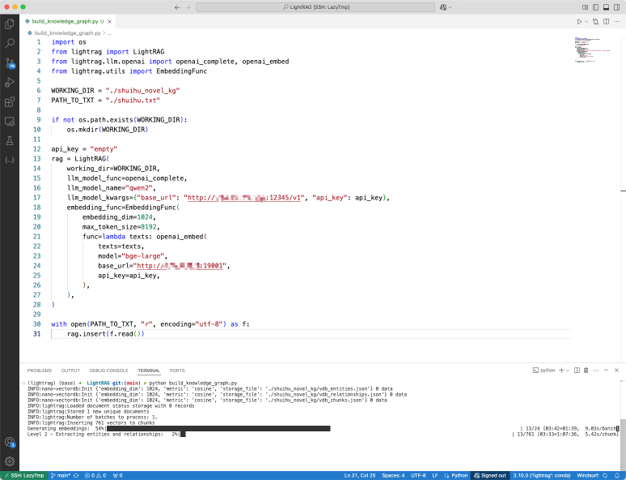

#### LightRAG基于知识图谱生成回答

[代码GitHub链接](https://github.com/LazyAGI/Tutorial/tree/main/rag/codes/chapter19/lightrag_ka_qa_demo.py)

In [ ]:
async def initialize_rag():
    rag = LightRAG(
        working_dir=WORKING_DIR,
        embedding_func=EmbeddingFunc(
                        embedding_dim=1024,
                        max_token_size=8192,
                        func=lambda texts: openai_embed(
                            texts=texts,model="bge-large",
                            base_url="http://127.0.0.1:19001", 
                            api_key=api_key,)
                    ),
        llm_model_func=openai_complete,
        llm_model_name="qwen2",
        llm_model_kwargs={"base_url":"http://0.0.0.0:12345/v1", 
                                         "api_key":api_key},
    )
    await rag.initialize_storages()
    await initialize_pipeline_status()
    return rag

In [ ]:
async def main():
    try:
        rag = await initialize_rag()
        with open(PATH_TO_TXT, "r", encoding="utf-8") as f:
            content = f.read()
        await rag.ainsert(content)
        mode = "hybrid"
        print(await rag.aquery("鲁智深打的是谁？", param=QueryParam(mode=mode)))
    except Exception as e:
        print(f"发生错误: {e}")
    finally:
        if rag:
            await rag.finalize_storages()

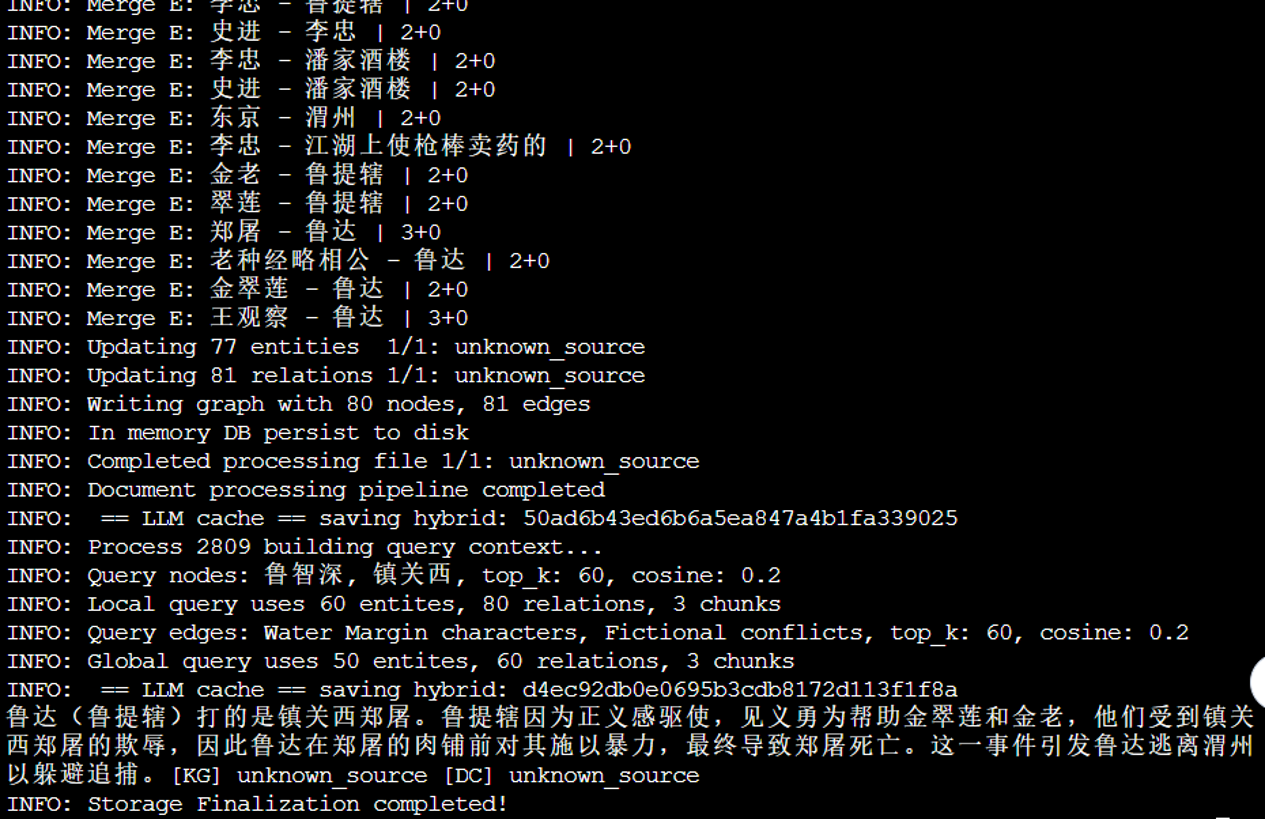

### 案例分析

#### Case1 实体查询类query

背景：鲁达（名）鲁提辖（官职），鲁智深（在五台山出家后的法名）。 在前六章，仅有"鲁达"和"鲁提辖"，而随着故事推进 "鲁智深"出现越来越多，到最后80章全部以"鲁智深"出现。

**Case1-1​**

| Query | 鲁提辖是怎么死的？ |
|-------|---------------------|
| Naive RAG | 根据提供的信息，我们无法直接得知鲁提辖（鲁智深）最终是如何死去的。资料中提到的部分主要是关于鲁提辖出早年行侠仗义的经历、打死镇关西的逃亡过程，以及后来成为花和尚的鲁智深因剿杀贼人守被掳的事件。但这些内容并未涉及他的死亡情况。<br><br>从《水浒传》完整情节来看，鲁智深最后是在征方腊之后圆寂的。在战役结束之后，鲁智深就感到自己命数将尽，于浙江六和寺坐化（即佛教中的安然离世）。他留下了一首偈子表明自己的心境，并且显示了他对尘世已毫无留恋，最终以一种平静且庄严的方式结束了他传奇的一生。不过，这一细节并未包含在您给出的知识段落内。 |
| Light RAG | 据提供的资料，鲁提辖（即后来出家为僧的鲁智深）并没有明确的死亡描述。相反，他的结局是在杭州六和寺坐化，也就是一种和尚修行到一定程度后自主选择的圆寂方式。这表明他最终选择了佛教的解脱之路，而非因战斗或其他原因去世。<br><br>具体描述如下：<br>- 鲁智深在《水浒传》中经历了多次战斗，展现了非凡的武艺和正义感。<br>- 最终，他在杭州六和寺实现了从武到僧转化的转变。<br>- 他在六和寺坐化，留下了颂词，体现了其放下执念和顿悟的精神转变。<br><br>因此，鲁提辖的结局是通过坐化完成了一种精神上的升华，而不是因外界因素导致的死亡。 |
| 分析 | Naive RAG：召回的内容都是82回之前含有鲁提辖的段落。 |

**Case 1-2**

表现近似Case1

| Query | **鲁达是怎么死的?** |
| --------- | --------------------------- |

**Case 1-3**

| Query | 鲁智深是怎么死的？ |
|-------|---------------------|
| Naive RAG | 根据提供的信息，鲁智深是在听了钱塘江的潮音之后，意识到自己到了该圆寂的时候。他沐浴更衣后，在寺庙的法堂上坐化了。具体过程如下：<br><br>1. 鲁智深听到钱塘江的潮声，误认为是战鼓声，后来得知是潮音。<br>2. 他突然想起师父智真长老曾经给他的四句偈语：“逢夏而潦，遇雨而毙。听潮而圆，见信而寂。”<br>3. 鲁智深明白偈语的意思，知道自己该圆寂了。<br>4. 他将昔日的俗人僧身份准备洗净水，换上新的僧衣。<br>5. 鲁智深写下了一篇颂子，内容是：“平生不修善果，只爱杀人放火。忽地顿开金枷，这里谢却红尘。唵！钱塘江上潮信来，今日方知我是我。”<br>6. 最后，他在法堂上坐化，双腿盘起，自然天性瞑目，安然圆寂。<br><br>因此，鲁智深是自愿选择在听到潮音后坐化圆寂的。 |
| LightRAG | 同1.1 |


#### Case 2 摘要总结类的query

背景：林冲的故事情节涉及章节较多：其加入梁山前的章节是中心人物集中出现，而后零散提及。

**Case 2-1**

| Query      | **林冲的主要事迹有哪些？**                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| ------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Naive RAG | 根据您提供的知识内容，林冲的主要事迹包括：<br><br>1. 被高太尉陷害，误入白虎节堂，被冤枉拿了刀进节堂意图刺杀高太尉，因此被逮捕。<br>2. 被判处刺配，送往沧州。<br>3. 在前往沧州的途中，经过野猪林，被押解的公人董超、薛霸想要杀死他，但被鲁智深所救。<br>4. 到达沧州后，林冲被安排看守天王堂，并后来被指派去看管草料场。<br>5. 高太尉派陆虞候到沧州谋害林冲，设计让草料场发生火灾并致林冲于死地。但林冲在听闻阴谋后避免了火灾，并杀死了想要陷害他的富安、陆谦以及差拨。<br>6. 杀人之后，林冲戴罪上路，遇见了之前曾在东京救助过的李小二，李小二及其妻子在林冲落难时对他十分照顾。<br>这些信息中描述了林冲几次非常关键的遭遇，最终导致他走上反抗的道路。                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| LightRAG   | 1. 身份转变：林冲原是东京八十万禁军的枪棒教头，因得罪高俅被陷害而被流放至沧州。在流放途中，受鲁智深的帮助，最终投奔了柴进，并后来加入了梁山泊。<br><br>2. 加入梁山泊：林冲因遭受高俅的迫害而被迫逃离京城，寻求庇护于柴进处。之后，他前往梁山泊并成为梁山的重要头领之一。他还协助推翻了原来的首领王伦，立晁盖为新的领导人。<br><br>3. 军事行动：<br>   - 参与攻打祝家庄的军事行动，作为第二拨的军事行动领导。<br>   - 在高唐州之战中直接与敌方交战。<br>   - 执行宋江命令，在宛州前线作战，是攻取宛州的关键人物之一。<br>   - 参与迎战辽国援军的战斗。<br>   - 在独松关的战斗中表现出色，成功地伤了蒋印。<br><br>4. 个人英勇表现：<br>   - 林冲多次在重要战役中展现了他的英勇和忠诚，与多位将领如关胜、王焕以及贺统军等对决，并取得了显著的战绩。<br>   - 他参与了多次军事行动，包括寻找卢俊义、护送宿太尉进辽国颁诏和计划参与对辽国军队的攻击等。<br><br>5. 患病与疗养：林冲后来染患风病瘫痪，留在六和寺中休养。<br><br>6. 忠诚与影响力：尽管在面对招安时内心有所质疑，但林冲对梁山泊的贡献和在英雄中的地位是无可替代的。他的英勇和忠诚在《水浒传》中留下了一段传奇。这些事迹展示了林冲从一名禁军教头到成为梁山重要头领的过程，以及他在多次战斗中的英勇表现和重要作用。 |
| 分析       | Naive RAG：受限于Token，召回的原文主要是上梁山前的内容。回复中不够广泛，但涉及细节较多。<br>LightRAG：召回的实体和关系偏重概括，回复中基本没有细节。                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |

**Case 2-2**

| Query      | **柴进帮助过谁？**                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| ------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| Naive RAG | 根据提供的知识内容，柴进帮助过以下这些人物：<br><br>1. 宋江：柴进见到宋江后非常高兴，还让宋江住在他庄上的客房里，为宋江做饭食款待；还给宋江换上了新衣服。<br>2. 林冲：柴进为了帮助林冲通过沧州道口离开，他还设计了一出打猎的戏码，假称林冲是其中一个猎人，顺利通过了守关的军官的搜检。<br>3. 卢俊义：柴进为了救卢俊义，亲自到蔡福家，拿出一千两黄金贿赂蔡福，要求蔡福放卢俊义一马。                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| LightRAG   | 根据提供的信息，柴进帮助过以下人物：<br><br>1. 宋江：宋江在杀死阎婆惜后，决定投奔柴进。柴进以主人之礼接待了宋江，并提供了庇护和优厚的招待。<br>2. 武松：武松因打伤人而逃到柴进庄上躲灾避难。柴进起初接纳并管待武松，尽管后来因武松性格刚烈，庄客不满，柴进对武松的态度逐渐冷淡，但离开时仍赠送金银。<br>3. 林冲：林冲被押解至沧州途中，受到庄客误解被吊在门楼下，最后被柴进救出并提供庇护。柴进还给林冲写了一封信推荐他去梁山泊，并为林冲的加入提供了便利。<br>4. 朱仝：柴进协助宋江策划了迫使朱仝加入梁山泊的计划，并在其中起到协调作用。<br>5. 叔叔柴皇城：当柴皇城生病时，柴进紧急奔赴高唐州探望，并在叔叔去世后，面对殷天锡的欺压，柴进誓言要为叔叔讨回公道。<br>6. 李逵：李逵随柴进前往高唐州探望生病的叔叔，在此过程中，李逵打死殷天锡后，柴进因此受牵连入狱，但显示了他对李逵某种程度上的间接保护。<br>7. 燕青：柴进与燕青共同执行细作任务，深入敌后，扮演主仆角色，成功完成任务。<br>8. 卢俊义：柴进代表宋江前往打听卢俊义的消息，并参与救援行动。<br>9. 萧让：柴进与萧让一同押送行军公文，陪同褚坚和宋江前去京城谈判。 |
| 分析       | Naive RAG：受限于Token，召回的原文基本上都是"柴进"集中出现较多的片段。召回广度低，细节程序高。<br>LightRAG：召回的广度更高。不过，可能因受对柴进角色刻画的影响，“柴进--朱仝” 和 "柴进--燕青" 的关系总结上，归为“帮助”略有牵强。                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |

**CASE 2-3 ​**

| Query      | **武松帮助过谁？**                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| ------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Naive RAG | 根据提供的信息，武松帮助过施恩。具体来说，施恩有一座酒肉店在城东快活林内，被蒋门神倚势豪强夺走。武松得知此事后，醉打了蒋门神，帮助施恩复夺了快活林。                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| LightRAG   | 根据提供的信息，武松帮助过以下人物：<br><br>1. 施恩：<br>- 武松帮助施恩夺回了被蒋门神霸占的快活林酒店的经营权。这展现了武松是施恩的一位强有力的帮手。<br>- 描述中提到：“武松帮助施恩夺回了快活林酒店的经营权，两人之间建立了信任和友谊的关系。”<br><br>2. 孔亮：<br>- 武松同意帮助孔亮，并计划一同攻打青州。此外，武松还帮助孔亮救了他的哥哥孔明和叔叔孔宾。<br><br>3. 张青和孙二娘：<br>- 虽然张青和孙二娘最初意图对武松不利，但后来他们成为朋友。武松在与他们的互动中表现出极大的正义感，间接帮助了他们避免了一场误会。<br><br>4. 宋江：<br>- 在某些情节中，武松作为宋江的手下参与了多项军事行动，如解救李逵、参与分兵进攻东门等，间接帮助了宋江巩固梁山泊的力量。<br><br>5. 亲戚和邻舍：<br>- 武松通过安排饮酒答谢活动来接触和了解他的邻舍，维护和改善关系，体现了他对周围人的关心。<br>- 例如，“武松邀请邻舍到家中饮酒答谢的事件，目的是安抚和进一步了解情况。”<br><br>6. 施恩的父亲（老管营）：<br>- 虽然没有明确提到武松直接帮助老管营，但通过帮助施恩，间接也使老管营受益。<br><br>总结来说，武松的主要帮助对象包括施恩、孔亮、张青夫妇、宋江以及周围的邻居和亲友。他的行为体现了强烈的忠义精神和反抗冤屈的勇气。 |
| 分析       | Naive RAG：实际上这个CASE受益于LLM幻觉，因为召回的内容中未出来 “夺回了被蒋门神霸占的快活林”。<br>LightRAG：召回的广度更高。不过，其中武松帮助了老管营略有牵强。（其属于召回的关系<施老管营, 施恩>: "施老管营是施恩的父亲，施恩得到武松的帮助夺回经营权，可能也会得到老管营的支持与协助。"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |

# LazyLLM融合LightRAG

整体流程图：

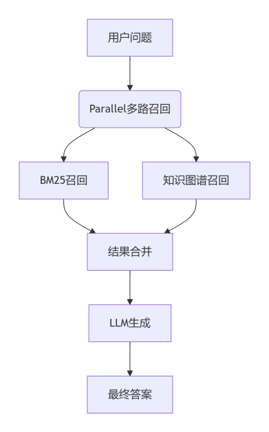

设置LightRAG知识图谱的存储目录`working_dir`和文本文件的路径`txt_path`，并配置LazyLLM知识库目录`dataset_path`

[代码GitHub链接](https://github.com/LazyAGI/Tutorial/tree/main/rag/codes/chapter19/lightrag_lazyllm_demo.py)

In [ ]:
import os
import asyncio
import lazyllm
from lazyllm import pipeline, parallel, bind, Retriever
from lightrag import LightRAG, QueryParam
from lightrag.kg.shared_storage import initialize_pipeline_status
from lightrag.utils import setup_logger, EmbeddingFunc
from lightrag.llm.openai import openai_complete, openai_embed

class LightRAGRetriever:
    def __init__(self, working_dir, txt_path, mode="hybrid"):
        self.working_dir = working_dir
        self.txt_path = txt_path
        self.mode = mode
        self.api_key = "empty"
        self.rag = None 
        self.loop = asyncio.new_event_loop()
        setup_logger("lightrag", level="INFO")

        if not os.path.exists(working_dir):
            os.makedirs(working_dir)

        self.loop.run_until_complete(self.initialize_rag())
    
    async def initialize_rag(self):
        self.rag = LightRAG(
            working_dir=self.working_dir,
            embedding_func=EmbeddingFunc(
                embedding_dim=1024,
                max_token_size=8192,
                func=lambda texts: openai_embed(
                    texts=texts,
                    model="bge-large",
                    base_url="http://0.0.0.0:19001",
                    api_key=self.api_key,
                )
            ),
            llm_model_func=openai_complete,
            llm_model_name="qwen2",
            llm_model_kwargs={"base_url": "http://0.0.0.0:12345/v1", "api_key": self.api_key},
        )
        await self.rag.initialize_storages()
        await initialize_pipeline_status()

        with open(self.txt_path, "r", encoding="utf-8") as f:
            content = f.read()
        await self.rag.ainsert(content)
    
    def __call__(self, query):
        return self.loop.run_until_complete(
            self.rag.aquery(
                query,
                param=QueryParam(mode=self.mode, top_k=3, only_need_context=True)
            )
        )
    
    def close(self):
        if self.rag:
            try:
                self.loop.run_until_complete(self.rag.finalize_storages())
            except Exception as e:
                print(f"关闭LightRAG时出错: {e}")
            finally:
                self.loop.close()
                self.rag = None

def main():
    kg_retriever = None
    try:
        documents = lazyllm.Document(dataset_path="****")
        prompt = ('请你参考所给的信息给出问题的答案。')

        print("正在初始化知识图谱检索器...")
        kg_retriever = LightRAGRetriever(
            working_dir="****",
            txt_path="****"
        )
        print("知识图谱检索器初始化完成！")

        bm25_retriever = lazyllm.Retriever(
            doc=documents,
            group_name="CoarseChunk",
            similarity="bm25_chinese",
            topk=3
        )
        
        def bm25_pipeline(query):
            nodes = bm25_retriever(query)
            return "".join([node.get_content() for node in nodes])

        def context_combiner(*args):
            bm25_result = args[0]
            kg_result = args[1]   
            return (
                f"知识图谱召回结果:\n{kg_result}"
                f"BM25召回结果:\n{bm25_result}\n\n"
            )

        with lazyllm.pipeline() as ppl:
            with parallel() as ppl.multi_retrieval:
                ppl.multi_retrieval.bm25 = bm25_pipeline
                ppl.multi_retrieval.kg = kg_retriever
            ppl.context_combiner = context_combiner
            ppl.formatter = (lambda nodes, query: dict(context_str=nodes, query=query)) | bind(query=ppl.input)
            ppl.llm = (
                lazyllm.OnlineChatModule().prompt(
                    lazyllm.ChatPrompter(
                        instruction=prompt,
                        extra_keys=['context_str']
                    )
                )
            )

        lazyllm.WebModule(ppl, port=23466).start().wait()
        
    except Exception as e:
        print(f"\n处理过程中发生错误: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

朴素RAG召回文本：

```bash
又只一拳，太阳穴上正着，却似做了一个全堂水陆的道场，磬儿、钹儿、铙儿，一齐响。鲁达看时，只见郑屠挺在地下，口里只有出的气，没有入的气，动弹不得。鲁提辖假意道：    “你这厮诈死，洒家再打。”只见面皮渐渐的变了。    鲁达寻思道：“俺只指望痛打这厮一顿，不想三拳真个打死了他，。洒家须吃官司，又没人送饭，不如及早撒开。”拔步便走，回头指着郑屠尸道：“你诈死，洒家和你慢慢理会。”    一头骂，一头大踏步去了。街坊邻舍并郑屠的火家，谁敢向前来拦他。鲁提辖回到下处，急急卷了一些衣服盘缠、细软银两，但是旧衣粗重都弃了。提了一根齐眉短棒，奔出南门，一道烟走了。    且说郑屠家中众人，救了半日不活，呜呼死了。老小邻人径来州衙告状。正直府尹升厅，接了状子，看罢道：“鲁达系是经略府的提辖，不敢擅自径来捕捉凶身。”府尹随即上轿，来到经略府前，下了轿子。把门军士入去报知，府中听得，教请到厅上，与府尹施礼罢。经略问道：“何来？”府尹禀道：“好教相公得知。府中提辖鲁达，无故用拳打死市上郑屠。不曾禀过相公，不敢擅自捉拿凶身。”经略听说，吃了一惊，寻思道：“这鲁达虽好武艺，只是性格粗卤，今番做出人命事，俺如何护得短？须教他推问使得。”经略回府尹道：“鲁达这人，原是我父亲老经略处的军官，为因俺这里无人帮护，拨他来做个提辖。既然犯了人命罪过，你可拿他依法度取问。如若供招明白，拟罪已定，也须教我父亲知道，方可断决。怕日后父亲处边上要这个人时，却不好看。”府尹禀道：“下官问了情由，合行申禀老经略相公知道，方可断遣。”府尹辞了经略相公，出到府前，上了轿，回到州衙里，措厅坐下。便唤当日缉捕使臣押下文书，捉拿犯人鲁达。    当时王观察领了公文，将带二十来个做公的人，径到鲁提辖下处。但见：    扶肩搭背，交颈并头。纷纷不辨贤愚，扰扰难分贵贱。张三蠢胖，不识字只把头摇；李四矮矬，看别人也将脚踏。白头老叟，尽将拐棒拄髭须；绿鬓书生，却把文房抄款目。行行总是萧何法，句句俱依律令行。    鲁达看见众人看榜，挨满在十字路口，也站在人丛里。听时，鲁达却不识字，只听得众人读道：“代州雁门县依奉太原府指挥使司，该准渭州文字，捕捉打死郑屠犯人鲁达，即系经略府提辖。如有人停藏在家宿食，与犯人同罪；若有人捕获前来，或告到官，支给赏钱一千贯文。”鲁提辖正听到那里，只听得背后有人大叫道：“张大哥。你如何到这里？”拦腰抱住，扯离了十字路口。    不是这个人看见了，横倒拖拽将去，有分教：鲁提辖剃除头发，削去髭须，倒换过杀人姓名，薅恼杀诸佛罗汉。直教：    禅杖打开危险路，戒刀杀尽不平人。毕竟扯住鲁提辖的是甚人，且听下回分解。若非雨病云愁，定是怀忧积恨。    那妇人拭着眼泪，向前来深深的道了三个万福。那老儿也都相见了。鲁达问道：“你两个是那里人家？为甚啼哭？”那妇人便道：“官人不知，容奴告禀：奴家是东京人氏。因同父母来这渭州，投奔亲眷，不想搬移南京去了。母亲在客店里染病身故，子父二人，流落在此生受。此间有个财主，叫做镇关西郑大官人，因见奴家，便使强媒硬保，要奴作妾。谁想写了三千贯文书，虚钱实契，要了奴家的身体，未及三个月，他家大娘子好生利害，将奴赶打出来，不容完聚，着落店主人家追要原典身钱三千贯。父亲懦弱，和他争执不得，他又有钱有势。当初不曾得他一文，如今那讨些钱还他？没计奈何，父亲自小教得奴家些小曲儿，来到这里酒楼上赶座。每日但得些钱来，将大半还他，留些少子父们盘缠。这两日酒客稀少，违了他钱限，怕他来讨时，受他羞耻。子父们想起这些苦楚来，无处告诉，因此啼哭。不想误触犯了官人，望乞恕罪，高抬贵手。”    鲁提辖又问道：“你姓甚么，在那个客店里歇？那个镇关西郑大官人在那里住？”老儿答道：“老汉姓金，排行第二。孩儿小字翠莲。郑大官人便是此间状元桥下卖肉的郑屠，绰号镇关西。老汉父子两个，只在前面东门里鲁家客店安下。”鲁达听了道：“呸！俺只道那个郑大官人，却原来是杀猪的郑屠。    这个腌筹泼才，投托着俺小种经略相公门下做个肉铺户，却原来这等欺负人！”回头看李忠、史进道：“你两个且在这里，等洒家去打死了那厮便来。”史进、李忠抱住劝道：“哥哥息怒，明日却理会。”两个三回五次劝得他住。    鲁达又道：“老儿，你来！洒家与你些盘缠，时日便回东京去如何？”父子两个告道：“若是能够回乡去时，便是重生父母，再长爷娘。只是店主人家如何肯放？郑大官人须着落他要钱。”鲁提辖道：“这个不妨事，俺自有道理。
```

LightRAG召回内容(Entities部分)：

```bash
-----Entities(KG)-----```json[{"id": "1", "entity": "金翠莲", "type": "person", "description": "金翠莲是金老的女儿，受到郑屠的不公平对待。<SEP>金翠莲是鲁达提到的一个女性，据推测她可能是被郑屠欺骗或伤害的对象。", "rank": 3, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "2", "entity": "鲁达", "type": "person", "description": "鲁达是一个强力的武官，积极帮助金老摆脱困境并惩罚了郑屠。<SEP>鲁达是一名经略府的提辖，以其武艺高强和性格粗犷著称，在故事中因打死郑屠而逃走。<SEP>鲁达是经略府的提辖，曾与史进在茶坊相遇，并愿意帮助史进寻找他的师父。<SEP>鲁达，也称鲁提辖，因打死郑屠而被捉拿在逃，是故事中的主要人物。", "rank": 18, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "3", "entity": "两个都头", "type": "person", "description": "两个都是官府中的官员，负责抓捕史进等人。", "rank": 2, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "4", "entity": "史进", "type": "person", "description": "史进是一位与鲁提辖一起行动的个人，也被称为史大郎，其师父是打虎将李忠。<SEP>史进是一位有义气的英雄，他在保护朱武三人免受官府逼迫的过程中，采取了紧张的行动，并最终决定离开家乡去寻找他的师父。<SEP>史进是一名清白的好汉，拒绝落草为寇，离开少华山，寻找他的师父王教头。<SEP>史进是与鲁提辖一同饮酒的同伴之一，提供了帮助金氏父女的一部分钱财。", "rank": 17, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "5", "entity": "杨春", "type": "person", "description": "杨春是史进朋友中的另一位头领，积极参与史进保护朱武等人并对抗官府的行动。", "rank": 1, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "6", "entity": "事件: 鲁达还房钱", "type": "event", "description": "鲁达提出支付郑屠的钱，以释放金老。", "rank": 0, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "7", "entity": "代州雁门县", "type": "geo", "description": "代州雁门县是鲁达逃亡过程中到达的一座城市。", "rank": 1, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "8", "entity": "事件公告", "type": "event", "description": "州衙厅发布的公告，悬赏捉拿鲁提辖的信息在代州雁门县发布。", "rank": 2, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}]
```

LightRAG召回内容(Relationships部分)：

```bash
-----Relationships(KG)-----```json[{"id": "1", "entity1": "金翠莲", "entity2": "鲁达", "description": "鲁达为了帮助金翠莲及其父亲而采取行动。<SEP>鲁达提及金翠莲，认为她是被郑屠欺骗的受害者。", "keywords": "受害者保护,忠义,救助", "weight": 14.0, "rank": 21, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "2", "entity1": "两个都头", "entity2": "史进", "description": "两个都头代表官府来抓捕史进，与史进及其同伙发生对抗。", "keywords": "对抗,抓捕", "weight": 9.0, "rank": 19, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "3", "entity1": "史进", "entity2": "杨春", "description": "史进和杨春共同行动以对抗官府并保护山寨成员。", "keywords": "合作,联盟", "weight": 8.0, "rank": 18, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "4", "entity1": "事件公告", "entity2": "鲁达", "description": "公告号召人们协助捉拿鲁提辖。", "keywords": "司法通缉", "weight": 9.0, "rank": 20, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "5", "entity1": "代州雁门县", "entity2": "鲁达", "description": "鲁达在逃亡过程中到达代州雁门县。", "keywords": "逃亡途点", "weight": 9.0, "rank": 19, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "6", "entity1": "事件公告", "entity2": "州衙厅", "description": "州衙厅发布有关鲁达的逃犯公告。", "keywords": "司法公告", "weight": 7.0, "rank": 4, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}]```
```

LightRAG召回内容(Document Chunks部分)：

```bash
-----Document Chunks(DC)-----```json[{"id": "1", "content": "上。鲁达再入一步，踏住胸脯，提着那醋钵儿大小拳头，看着这郑屠道：\n\n    “洒家始投老种经略相公，做到关西五路廉访使，也不枉了叫做镇关西。你是个卖肉的操刀屠户，狗一般的人，也叫做镇关西！你如何强骗了金翠莲？”扑的只一拳，正打在鼻子上，打得鲜血迸流，鼻子歪在半边，却便似开了个油酱铺，咸的、酸的、辣的，一发都滚了出来。郑屠挣不起来，那把尖刀也丢在一边，口里只叫：“打得好！”鲁达骂道：“直娘贼，还敢应口！”提起拳头，就眼眶际眉梢只一拳，打得眼棱缝裂，乌珠迸出，也似开了个彩帛铺的，红的、黑的、绛的，都绽将出来。两边看的人，惧怕鲁提辖，谁敢向前来劝？\n\n    郑屠当不过，讨饶。鲁达喝道：“咄！你是个破落户，若是和俺硬到底，洒家倒饶了你；你如何对俺讨饶，洒家偏不饶你。”又只一拳，太阳穴上正着，却似做了一个全堂水陆的道场，磬儿、钹儿、铙儿，一齐响。鲁达看时，只见郑屠挺在地下，口里只有出的气，没有入的气，动弹不得。鲁提辖假意道：\n\n    “你这厮诈死，洒家再打。”只见面皮渐渐的变了。\n\n    鲁达寻思道：“俺只指望痛打这厮一顿，不想三拳真个打死了他，。洒家须吃官司，又没人送饭，不如及早撒开。”拔步便走，回头指着郑屠尸道：“你诈死，洒家和你慢慢理会。”\n\n    一头骂，一头大踏步去了。街坊邻舍并郑屠的火家，谁敢向前来拦他。鲁提辖回到下处，急急卷了一些衣服盘缠、细软银两，但是旧衣粗重都弃了。提了一根齐眉短棒，奔出南门，一道烟走了。\n\n    且说郑屠家中众人，救了半日不活，呜呼死了。老小邻人径来州衙告状。正直府尹升厅，接了状子，看罢道：“鲁达系是经略府的提辖，不敢擅自径来捕捉凶身。”府尹随即上轿，来到经略府前，下了轿子。把门军士入去报知，府中听得，教请到厅上，与府尹施礼罢。经略问道：“何来？”府尹禀道：“好教相公得知。府中提辖鲁达，无故用拳打死市上郑屠。不曾禀过相公，不敢擅自捉拿凶身。”经略听说，吃了一惊，寻思道：“这鲁达虽好武艺，只是性格粗卤，今番做出人命事，俺如何护得短？须教他推问使得。”经略回府尹道：“鲁达这人，原是我父亲老经略处的军官，为因俺这里无人帮护，拨他来做个提辖。既然犯了人命罪过，你可拿他依法度取问。如若供招明白，拟罪已定，也须教我父亲知道，方可断决。怕日后父亲处边上要这个人时，却不好看。”府尹禀道：“下官问了情由，合行申禀老经略相公知道，方可断遣。”府尹辞了经略相公，出到府前，上了轿，回到州衙里，措厅坐下。便唤当日缉捕使臣押下文书，捉拿犯人鲁达。\n\n    当时王观察领了公文，将带二十来个做公的人，径到鲁提辖下处。只见房主人道：“却才?了些包裹，提了短棒出去了。小人只道奉着差使，又不敢问他。”王观察听了，教打开他房门看时，只有些旧衣旧裳和些被卧在里面。王观察就带了房主人，东西四下里去跟寻，州南走到州北，捉拿不见。王观察又捉了两家邻舍并房主人，同到州衙厅上回话道：“鲁提辖惧罪在逃，不知去向，只拿得房主人并邻舍在此。”府尹见说，且教监下；一面教拘集郑屠家邻佑人等，点了仵作", "file_path": "unknown_source"}, …….
```

RAG多路召回合并后输入给LLM的信息：

```bash
{'messages': [{'role': 'system', 'content': 'You are an AI assistant, developed by SenseTime.\n请你参考所给的信息给出问题的答案.\nHere are some extra messages you can referred to:\n\n### context_str:\n知识图谱召回结果:\n-----Entities(KG)-----\n\n```json\n[{"id": "1", "entity": "金翠莲", "type": "person", "description": "金翠莲是金老的女儿，受到郑屠的不公平对待。<SEP>金翠莲是鲁达提到的一个女性，据推测她可能是被郑屠欺骗或伤害的对象。", "rank": 3, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "2", "entity": "鲁达", "type": "person", "description": "鲁达是一个强力的武官，积极帮助金老摆脱困境并惩罚了郑屠。<SEP>鲁达是一名经略府的提辖，以其武艺高强和性格粗犷著称，在故事中因打死郑屠而逃走。<SEP>鲁达是经略府的提辖，曾与史进在茶坊相遇，并愿意帮助史进寻找他的师父。<SEP>鲁达，也称鲁提辖，因打死郑屠而被捉拿在逃，是故事中的主要人物。", "rank": 18, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, {"id": "3", "entity": "两个都头", "type": "person", "description": "两个都是官府中的官员，负责抓捕史进等人。", "rank": 2, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}, ......]\n```\n\n-----Relationships(KG)-----\n\n```json\n[{"id": "1", "entity1": "金翠莲", "entity2": "鲁达", "description": "鲁达为了帮助金翠莲及其父亲而采取行动。<SEP>鲁达提及金翠莲，认为她是被郑屠欺骗的受害者。", "keywords": "受害者保护,忠义,救助", "weight": 14.0, "rank": 21, "created_at": "2025-06-10 00:06:37", "file_path": "unknown_source"}......]\n```\n\n-----Document Chunks(DC)-----\n\n```json\n[{"id": "1", "content": "上。鲁达再入一步，踏住胸脯，提着那醋钵儿大小拳头，看着这郑屠道：\\n\\n    “洒家始投老种经略相公，做到关西五路廉访使，也不枉了叫做镇关西。你是个卖肉的操刀屠户，狗一般的人，也叫做镇关西！你如何强骗了金翠莲？”扑的只一拳，正打在鼻子上，打得鲜血迸流，鼻子歪在半边，却便似开了个油酱铺，咸的、酸的、辣的，一发都滚了出来。郑屠挣不起来，那把尖刀也丢在一边，口里只叫：“打得好！”鲁达骂道：“直娘贼，还敢应口！”提起拳头，就眼眶际眉梢只一拳，打得眼棱缝裂，乌珠迸出，也似开了个彩帛铺的，红的、黑的、绛的，都绽将出来。两边看的人，惧怕鲁提辖，谁敢向前来劝？\\n\\n    郑屠当不过，讨饶。鲁达喝道：“咄！你是个破落户，若是和俺硬到底，洒家倒饶了你；你如何对俺讨饶，洒家偏不饶你。”又只一拳，太阳穴上正着，却似做了一个全堂水陆的道场，磬儿、钹儿、铙儿，一齐响。鲁达看时，只见郑屠挺在地下，口里只有出的气，没有入的气，动弹不得。鲁提辖假意道：\\n\\n    “你这厮诈死，洒家再打。”只见面皮渐渐的变了。\\n\\n    鲁达寻思道：“俺只指望痛打这厮一顿，不想三拳真个打死了他，。洒家须吃官司，又没人送饭，不如及早撒开。”拔步便走，回头指着郑屠尸道：“你诈死，洒家和你慢慢理会。”\\n\\n    一头骂，一头大踏步去了。街坊邻舍并郑屠的火家，谁敢向前来拦他。鲁提辖回到下处，急急卷了一些衣服盘缠、细软银两，但是旧衣粗重都弃了。提了一根齐眉短棒，奔出南门，一道烟走了。\\n\\n    且说郑屠家中众人，救了半日不活，呜呼死了。......]\n```\n\nBM25召回结果:\n”又只一拳，太阳穴上正着，却似做了一个全堂水陆的道场，磬儿、钹儿、铙儿，一齐响。鲁达看时，只见郑屠挺在地下，口里只有出的气，没有入的气，动弹不得。鲁提辖假意道：\r\n\r\n    “你这厮诈死，洒家再打。”只见面皮渐渐的变了。\r\n\r\n    鲁达寻思道：“俺只指望痛打这厮一顿，不想三拳真个打死了他，。洒家须吃官司，又没人送饭，不如及早撒开。”拔步便走，回头指着郑屠尸道：“你诈死，洒家和你慢慢理会。”\r\n\r\n    一头骂，一头大踏步去了。街坊邻舍并郑屠的火家，谁敢向前来拦他。鲁提辖回到下处，急急卷了一些衣服盘缠、细软银两，但是旧衣粗重都弃了。提了一根齐眉短棒，奔出南门，一道烟走了。\r\n\r\n    ......'}, {'role': 'user', 'content': '鲁智深打死的是谁？'}], 'model': 'SenseChat-5', 'stream': True}
```

[相关视频：video/LazyLLM融合LightRAG.mp4](video/LazyLLM融合LightRAG.mp4)

## 参考文献

微软Graph RAG ：https://www.microsoft.com/en-us/research/project/graphrag/

LightRAG: https://arxiv.org/pdf/2410.05779